# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Описание данных <a class="tocSkip">

    

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
pd.set_option('max_columns', None)      # Покажем все столбцы, т.к. pandas выводит только 20.
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В данных 23699 строк, 22 столбца, в 14 из них есть пропуски, посмотрим процент пропусков по столбцам и проверим на явные дубликаты.

In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().mean().sort_values(ascending=False)

is_apartment            0.882906
parks_nearest           0.659100
ponds_nearest           0.615596
balcony                 0.486054
ceiling_height          0.387991
airports_nearest        0.233850
cityCenters_nearest     0.232879
ponds_around3000        0.232837
parks_around3000        0.232837
days_exposition         0.134225
kitchen_area            0.096122
living_area             0.080299
floors_total            0.003629
locality_name           0.002068
total_images            0.000000
last_price              0.000000
studio                  0.000000
floor                   0.000000
rooms                   0.000000
first_day_exposition    0.000000
total_area              0.000000
open_plan               0.000000
dtype: float64

Есть столбцы в которых более 50% пропусков, пройдемся по порядку по всем столбцам, где можно, заполним пропуски.

Построим гистограмму для всех столбцов таблицы.

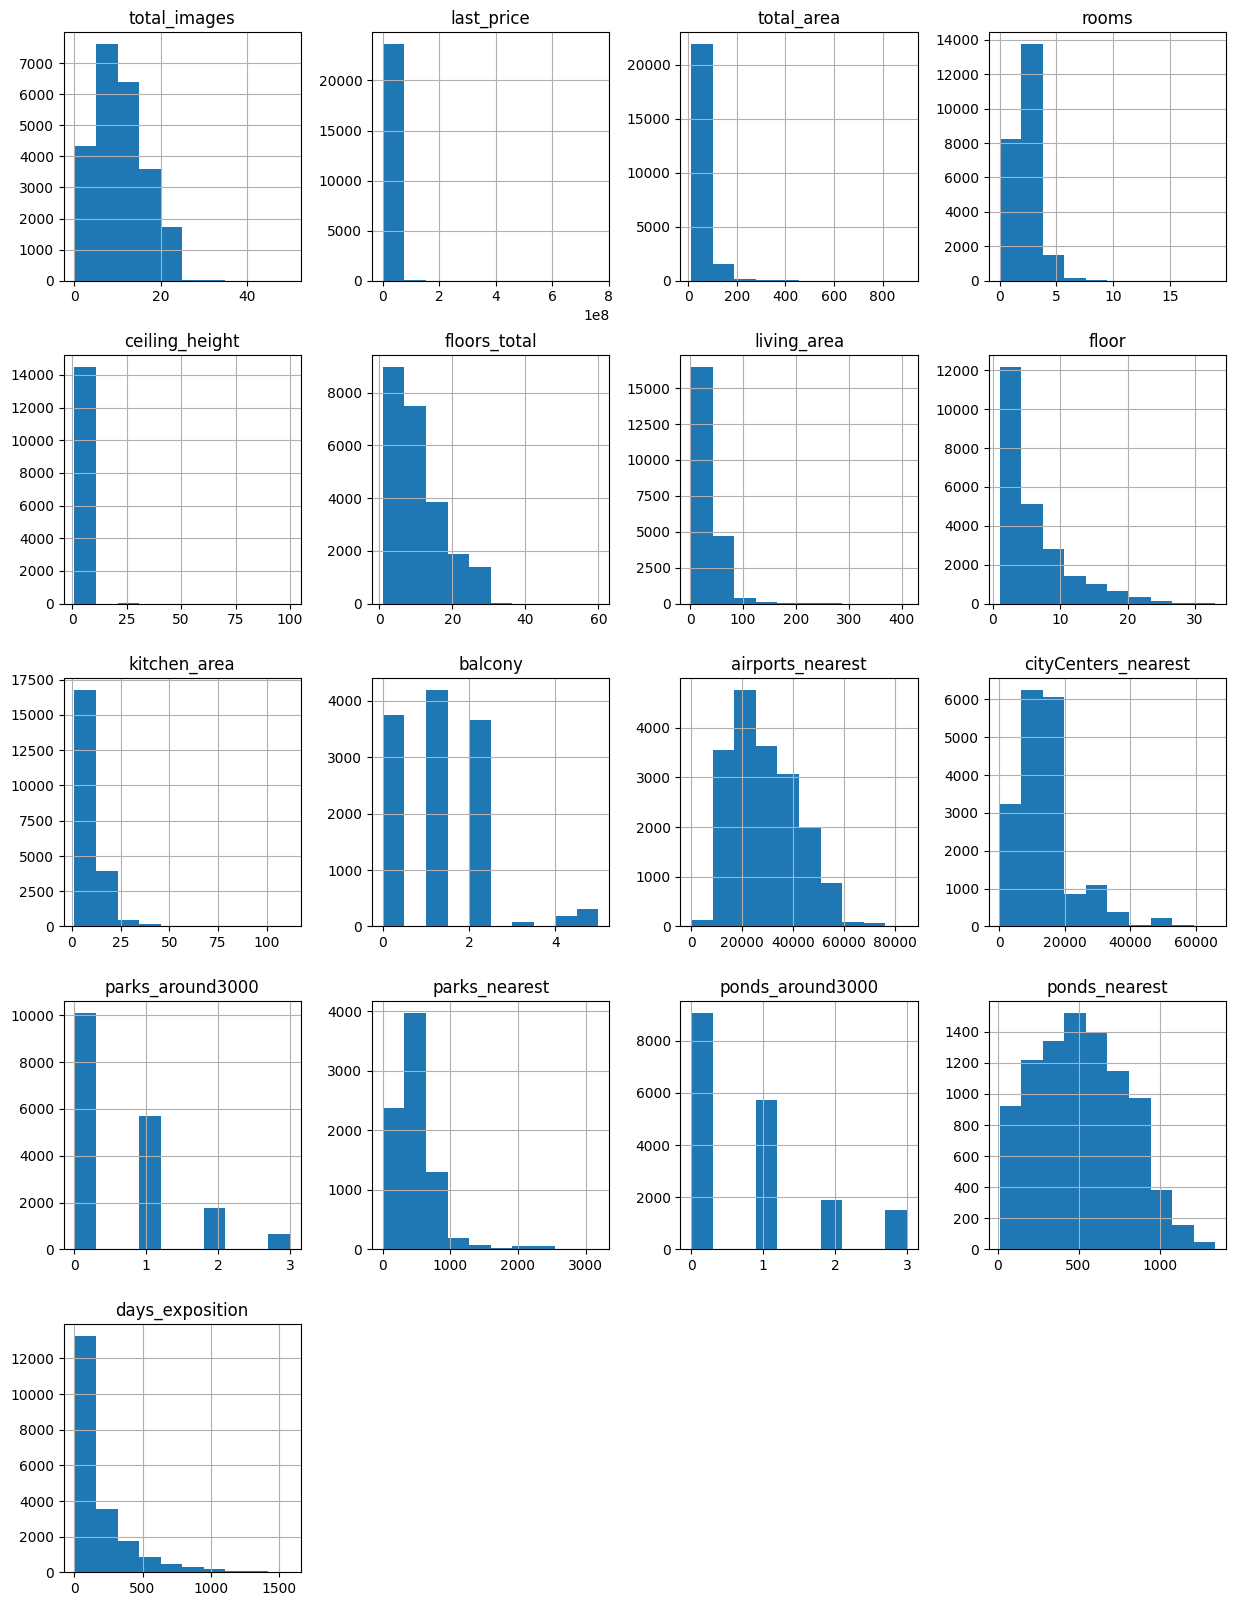

In [6]:
df.hist(figsize=(15, 20));

По гистограмам хорошо видно как распределяются значения в каждом столбце. В некоторых столбцах присутствуют аномально высокие значение, из-за которых все остальные значение попадают в один столбец. Например это столбцы  'last_price','total_area','rooms' и т.д.

### Предобработка данных

#### Пропуски данных

**Рассматриваем столбец 'ceiling_height'**

In [7]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Медиана и среднее арифметическое слабо отличиются, присутствуют странные крайние значение - 1м и 100м.  
Посмотрим что это за строки с высотой 1м и 100м , где возможно удалим явные ошибки, остальные пропуски заполним медианным значением.

(1.0, 100.0)

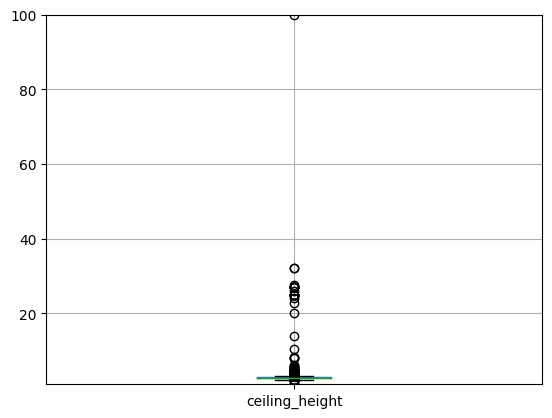

In [8]:
df.boxplot('ceiling_height');
plt.ylim(1,100) 

Есть только одно объявление с ценой 100м и видно огромное количество выбросов, приблизим график.

(1.0, 5.0)

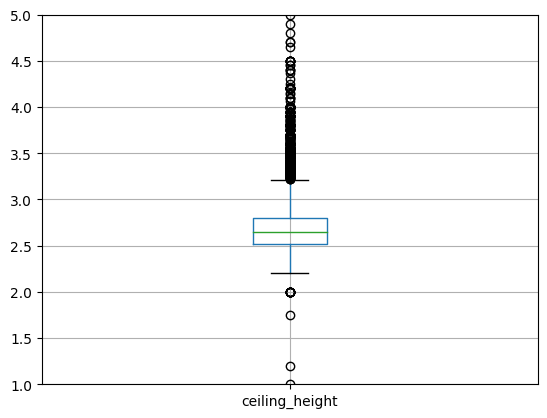

In [9]:
df.boxplot('ceiling_height');
plt.ylim(1,5) 

Теперь стало видно, что есть выбросы и снизу и сверху.

In [10]:
df.sort_values('ceiling_height', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,False,False,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0
22336,19,9999000.0,92.4,2019-04-05T00:00:00,2,32.0,6.0,55.5,5,False,False,False,16.5,4.0,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,False,False,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21377,19,4900000.0,42.0,2017-04-18T00:00:00,1,27.5,24.0,37.7,19,False,False,False,11.0,2.0,Санкт-Петербург,42742.0,9760.0,0.0,NaN,0.0,NaN,61.0
20478,11,8000000.0,45.0,2017-07-18T00:00:00,1,27.0,4.0,22.0,2,NaN,False,False,10.0,1.0,Санкт-Петербург,18975.0,3246.0,0.0,NaN,3.0,449.0,429.0
5246,0,2500000.0,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,NaN,False,False,9.0,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,NaN,False,False,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
10773,8,3800000.0,58.0,2017-10-13T00:00:00,2,27.0,10.0,30.1,3,False,False,False,8.1,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,71.0
17857,1,3900000.0,56.0,2017-12-22T00:00:00,3,27.0,5.0,33.0,4,False,False,False,NaN,NaN,Санкт-Петербург,41030.0,15543.0,0.0,NaN,0.0,NaN,73.0
22938,14,4000000.0,98.0,2018-03-15T00:00:00,4,27.0,2.0,73.0,2,True,False,False,9.0,1.0,деревня Нижняя,NaN,NaN,NaN,NaN,NaN,NaN,27.0


Если рассмотреть объявление с высотой 100м видно, что это квартира площадью 25м2 стоимость 15млн. В которой 5 балконов, а общая площать равна сумме жилой площади и кухни, что невозможно для квартиры, т.к. есть блаконы, еще должен быть туалет, коридор.  
Скорее всего в данных по этой квартире много ошибок, поэтому удалим ее из таблицы.

In [11]:
df.drop(index=22869, inplace=True)

In [12]:
df.sort_values('ceiling_height', ascending=False).head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22336,19,9999000.0,92.4,2019-04-05T00:00:00,2,32.0,6.0,55.5,5,False,False,False,16.5,4.0,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,False,False,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Касаемо остальных показателей, очень похоже чтобы введены данные с неправильным разрядом, например, 32 - 3,2м; 27 - 2,7м.

In [13]:
df['ceiling_height'].sort_values().unique()

array([ 1.  ,  1.2 ,  1.75,  2.  ,  2.2 ,  2.25,  2.3 ,  2.34,  2.4 ,
        2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,  2.51,  2.52,  2.53,
        2.54,  2.55,  2.56,  2.57,  2.58,  2.59,  2.6 ,  2.61,  2.62,
        2.63,  2.64,  2.65,  2.66,  2.67,  2.68,  2.69,  2.7 ,  2.71,
        2.72,  2.73,  2.74,  2.75,  2.76,  2.77,  2.78,  2.79,  2.8 ,
        2.81,  2.82,  2.83,  2.84,  2.85,  2.86,  2.87,  2.88,  2.89,
        2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,  2.96,  2.97,  2.98,
        2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,  3.07,
        3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,  3.16,
        3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,  3.26,
        3.27,  3.28,  3.29,  3.3 ,  3.31,  3.32,  3.33,  3.34,  3.35,
        3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,  3.43,  3.44,  3.45,
        3.46,  3.47,  3.48,  3.49,  3.5 ,  3.51,  3.52,  3.53,  3.54,
        3.55,  3.56,  3.57,  3.58,  3.59,  3.6 ,  3.62,  3.63,  3.65,
        3.66,  3.67,

Все потолки выше 20 метров поделим на 10.

In [14]:
df.loc[df['ceiling_height'] > 20, 'ceiling_height'] = df['ceiling_height'] /10

In [15]:
df['ceiling_height'].sort_values().unique()

array([ 1.  ,  1.2 ,  1.75,  2.  ,  2.2 ,  2.25,  2.26,  2.3 ,  2.34,
        2.4 ,  2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,  2.51,  2.52,
        2.53,  2.54,  2.55,  2.56,  2.57,  2.58,  2.59,  2.6 ,  2.61,
        2.62,  2.63,  2.64,  2.65,  2.66,  2.67,  2.68,  2.69,  2.7 ,
        2.71,  2.72,  2.73,  2.74,  2.75,  2.76,  2.77,  2.78,  2.79,
        2.8 ,  2.81,  2.82,  2.83,  2.84,  2.85,  2.86,  2.87,  2.88,
        2.89,  2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,  2.96,  2.97,
        2.98,  2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,
        3.07,  3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,
        3.16,  3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,
        3.26,  3.27,  3.28,  3.29,  3.3 ,  3.31,  3.32,  3.33,  3.34,
        3.35,  3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,  3.43,  3.44,
        3.45,  3.46,  3.47,  3.48,  3.49,  3.5 ,  3.51,  3.52,  3.53,
        3.54,  3.55,  3.56,  3.57,  3.58,  3.59,  3.6 ,  3.62,  3.63,
        3.65,  3.66,

Видим что ушли все значение выше 20м. У нас еще есть высоты 1м и 10м, которые нереальны для квартир.

In [16]:
df['ceiling_height'].describe()

count    14503.000000
mean         2.730348
std          0.345248
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         20.000000
Name: ceiling_height, dtype: float64

После наших преобразований среднее арифмитическое упало на 0.04м, а медиана не поменялась.  
Это связано с тем, что значений с анамально высокими потолками было слишком мало.
Посмотрим какой процент квартир с потолоками < 2,5м и 3.5м.

In [17]:
len(df.query('ceiling_height < 2.5 | ceiling_height > 3.5'))

357

In [18]:
len(df.query('ceiling_height < 2.5 | ceiling_height > 3.5')) / len(df)

0.015064562410329985

Таких квартир 1,5% от общего количества. Они не сыграют роль на медианное значение, поэтому оставим их без изменений, далее заполним все пропуски медианным значением.

In [19]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

In [20]:
df['ceiling_height'].isna().sum()

0

Пропуски устранены, перейдем к следующему столбцу.

**Пропуски в 'floors_total'**

В столбце всего 86 строк с пропусками, удалим их.

In [21]:
df = df.dropna(subset=['floors_total'])

In [22]:
df['floors_total'].isna().mean()

0.0

Пропуски удалены.

**Столбец 'living_area'**

Посмотрим структуру столбца и несколько строчек с пропусками.

In [23]:
df['living_area'].describe()

count    21742.000000
mean        34.463722
std         22.037503
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [24]:
df[df['living_area'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.65,24.0,NaN,22,NaN,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.65,9.0,NaN,2,NaN,False,False,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,NaN,False,False,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.65,22.0,NaN,3,NaN,False,False,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN


В этом столбце у нас 8% пропусков. Логично предположить что жилая площадь напрямую зависит от общей площади. Посмотрим на график зависимости этих столбцов.

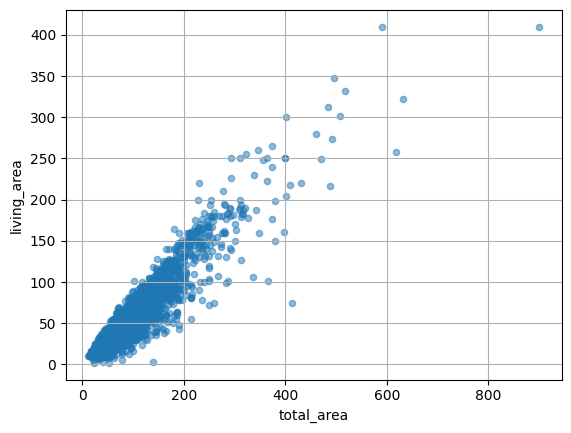

In [25]:
df.plot(x='total_area', y='living_area', kind='scatter', grid=True, alpha=0.5);

Видна линейная зависимость - с ростом общей площади, расчет жилая площадь.  
Найдем как относятся жилая площадь к общей площади и заполним пропуски с помощью этого коэф.
Прежде чем заполнять пропуски, выполним проверку: (жилая площадь + кухня) не должны превышать 90% общей площади.

Проверим коэф. корреляции.

In [26]:
df['total_area'].corr(df['living_area'])

0.9397680353697999

Видно очень сильная линейная связь, заполнять будем с помощью коэф.

Для начала выполним проврку нет ли аномалий что жилая площадь и кухня превышают 90% общей площади, т.к. еще есть туалет, коридор.

In [27]:
df[df['living_area'] + df['kitchen_area'] > 0.9*df['total_area']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
41,16,7900000.0,74.0,2016-05-04T00:00:00,3,2.65,14.0,59.0,8,False,False,False,12.0,5.0,Санкт-Петербург,37715.0,12612.0,1.0,725.0,1.0,759.0,179.0
171,6,3800000.0,49.0,2019-02-22T00:00:00,2,2.50,9.0,38.0,8,NaN,False,False,10.0,1.0,посёлок Шушары,18471.0,24272.0,0.0,NaN,0.0,NaN,11.0
184,7,2600000.0,30.2,2018-02-14T00:00:00,1,2.65,9.0,26.1,5,NaN,False,False,6.2,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
220,8,3890000.0,37.0,2018-07-09T00:00:00,1,2.50,25.0,28.0,6,NaN,False,False,9.0,NaN,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0
319,19,4850000.0,59.7,2015-03-19T00:00:00,3,2.50,5.0,47.4,4,NaN,False,False,6.4,1.0,Санкт-Петербург,43095.0,15599.0,0.0,NaN,0.0,NaN,974.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23216,15,10150000.0,114.0,2015-01-21T00:00:00,4,2.65,5.0,90.2,4,NaN,False,False,16.0,NaN,Санкт-Петербург,26259.0,4961.0,0.0,NaN,2.0,838.0,1052.0
23297,10,1850000.0,48.2,2019-03-13T00:00:00,2,2.65,5.0,42.2,2,NaN,False,False,6.0,1.0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23328,12,4299000.0,54.0,2016-11-25T00:00:00,2,2.65,14.0,40.0,8,NaN,False,False,10.0,0.0,Колпино,25612.0,31399.0,0.0,NaN,0.0,NaN,343.0
23521,13,8500000.0,65.0,2018-11-01T00:00:00,2,2.65,4.0,44.0,2,NaN,False,False,15.3,NaN,Санкт-Петербург,22276.0,3996.0,1.0,627.0,0.0,NaN,NaN


У нас есть такие, квартиры, их 460 шт. Сложно сказать почему это произошло, возможно была просто ошибка при внесении данных, возможно при публикации объявления продавец посчитал кухню в жилой площади и произвошло задвоение. 
Т.к. мы не знаем явную причину и так их квартир всего 460 (2% всех данных), а площадь квартир это основной критерий который влияет на стоимость, то удалим эти данные.

In [28]:
df = df[~(df['living_area'] + df['kitchen_area'] > 0.9 * df['total_area'])]

Выполним проверку.

In [29]:
df[df['living_area'] + df['kitchen_area'] > 0.9* df['total_area']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Проверка пройдена успешно, данные удалены.  
Теперь найдем коэф. умножив на который мы найдем жилую площадь для пропусков и заполним их.

In [30]:
t = (df['living_area'] / df['total_area']).mean()
t

0.5612022229729131

In [31]:
warnings.filterwarnings('ignore')   # Отключаем предупреждения.

In [32]:
df['living_area'] = df['living_area'].fillna(t*df['total_area'])

In [33]:
df[df['living_area'] + df['kitchen_area'] > 0.9* df['total_area']].shape

(31, 22)

У нас появилось 31 аномальное значание, удалим их.

In [34]:
df = df[~(df['living_area'] + df['kitchen_area'] > 0.9 * df['total_area'])]

**Столбец 'kitchen_area'**

Вероятнее всего здесь такая же зависимость. Посмотрим график.

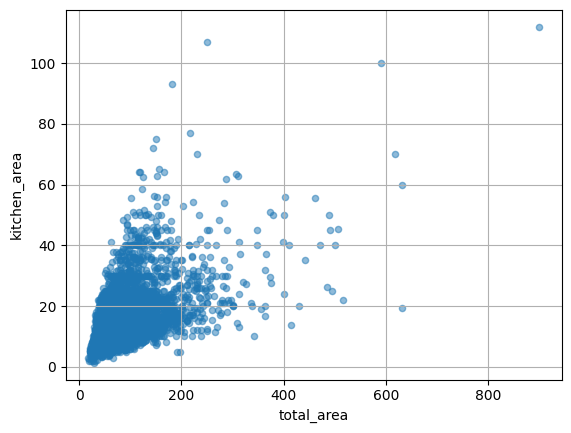

In [35]:
df.plot(x='total_area', y='kitchen_area', kind='scatter', grid=True, alpha=0.5);

Да, видна зависимость, что с ростом общей площади расчет и площадь кухни, но на графике виден очень сильный разброс, поэтому заполнять площадь с помощью коэф. будет не совем правильно. Оставим эти поля пустыми.

**Столбец 'is_apartment'**

In [36]:
df['is_apartment'].isna().mean()

0.8827472860170408

В этом столбце 88% пропусков.

In [37]:
df['is_apartment'].value_counts()

False    2665
True       46
Name: is_apartment, dtype: int64

Причем из всего столбца только 50 значений "Да". По этим данным нельзя делать вывод.  
Можно предположить что все незаполненные значения это "Нет", но все равно значений "Да" слишком мало,  
чтобы на основе данных можно было делать какой-то анализ, поэтому удалим полностью этот столбец.

In [38]:
df.drop(columns='is_apartment', axis= 1 , inplace= True )

In [39]:
df.shape     # Проверка

(23121, 21)

**Столбец 'balcony'**

In [40]:
df['balcony'].isna().mean()

0.4846243674581549

In [41]:
df['balcony'].value_counts()

1.0    4124
0.0    3660
2.0    3579
5.0     298
4.0     177
3.0      78
Name: balcony, dtype: int64

Маловероятно что количество балконов играет большую роль на оценку квартиры.  
Предпложим что продавец не заполнил этот столбец потому что в квартире нет балконов. Заполнил все пустые значения нулями.

In [42]:
df['balcony'] = df['balcony'].fillna(0)

In [43]:
df['balcony'].isna().sum()   # Проверка

0

**Столбец 'locality_name'**

In [44]:
df['locality_name'].isna().mean()

0.0020760347735824577

Очень хорошо что у нас только 0,2% пропусков, поэтому что населенный пункт играет основную роль при формировании стоимости.  
Удалим строки без населенных пунктов.

In [45]:
df = df.dropna(subset=['locality_name'])

In [46]:
df['locality_name'].isna().mean()

0.0

Пока рассматриваем этот столбец, посмотрим нет ли неявных дубликатов.

In [47]:
t= df['locality_name'].unique()
t.sort()
t

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

В таком перечне очень тяжело найти одинаковые значения.
Из возможных дубликатов нашел следующие варианты:
- "посёлок" заменить на "поселок"
- "городской поселок" заменить на "поселок городского типа"
- "Мурино" и "поселок Мурино", "Кудрово" и "поселок Кудрово" (в 2018 году деревня Кудрово получила статус города)

Предварительно посмотрим сколько у нас уникальных значений в исходных данных.

In [48]:
df['locality_name'].nunique()

362

364 уникальных значений.

In [49]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е')

In [50]:
df['locality_name'] = df['locality_name'].str.replace('городской поселок', 'поселок городского типа')

In [51]:
df['locality_name'] = df['locality_name'].replace({'поселок Мурино':'Мурино', 'деревня Кудрово':'Кудрово'})

In [52]:
df['locality_name'].nunique()

319

Около 12% дубликатов смогли убрать.

**Столбцы 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest'**

Мы выполнили преодбработку данных, которые пользователи заполняли вручную, теперь рассмотрим столбцы. которые формировались в автоматическом порядке. Давайте таблицы с прпусками в столбце 'airports_nearest'.

In [53]:
df[df['airports_nearest'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.400000,5,False,False,9.10,0.0,поселок городского типа Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.430000,26,False,False,8.81,0.0,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.65,5.0,30.000000,5,False,False,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.000000,15,False,False,11.00,2.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.65,9.0,18.407433,2,False,False,NaN,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0


По первым 10 строчкам, где незаполнено "airports_nearest", не заполнены и другие столбцы связанные с растоянием.  
Проверим это.

In [54]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5388
cityCenters_nearest      5365
parks_around3000         5364
parks_nearest           15226
ponds_around3000         5364
ponds_nearest           14231
days_exposition          3087
dtype: int64

In [55]:
df.query('airports_nearest.isna() and \
          cityCenters_nearest.isna() and \
          parks_around3000.isna() and \
          parks_nearest.isna() and \
          ponds_around3000.isna() and \
          ponds_nearest.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.400000,5,False,False,9.10,0.0,поселок городского типа Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.430000,26,False,False,8.81,0.0,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.65,5.0,30.000000,5,False,False,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.000000,15,False,False,11.00,2.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.65,9.0,18.407433,2,False,False,NaN,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.500000,3,False,False,5.50,0.0,поселок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,2.65,5.0,17.500000,4,False,False,6.00,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.65,5.0,38.000000,4,False,False,8.50,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.65,3.0,29.700000,1,False,False,NaN,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Действительно, все эти пропуски пересекаются. Непонятно почему это произошло.
Но это хорошая новость, в том плане, что у нас нет данных по одним и тем же объектам (около 23%), зато по всем остальным данным мы имеем полную картину.  
Так интресно посмотреть где расположены эти объекты, возможно они все находятся за предалами Санкт-Петербурга.

In [56]:
df.query('airports_nearest.isna() and \
          cityCenters_nearest.isna() and \
          parks_around3000.isna() and \
          parks_nearest.isna() and \
          ponds_around3000.isna() and \
          ponds_nearest.isna() and \
          locality_name == "Санкт-Петербург"')['locality_name'].count()

59

Всего 59 объектов из Санкт-Петербурга с пропущенными данными по геопозиции.

Так же есть столбцы 'parks_nearest' и 'ponds_nearest', где более 60% пропусков.

In [57]:
df['parks_nearest'].describe()

count    7847.000000
mean      491.009558
std       341.289386
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [58]:
df['ponds_nearest'].describe()

count    8842.000000
mean      518.611853
std       278.001166
min        13.000000
25%       294.000000
50%       503.000000
75%       730.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

Там 60% пропусков это очень много, ничем не будем их заполнять, чтобы не исказать данные.  
Если что, есть столбцы 'parks_around3000' и 'ponds_around3000', этого должны быть достаточно для анализа, 

**Столбец 'days_exposition'**

In [59]:
df['days_exposition'].isna().mean()

0.13379274476661032

В данном столбце 13%.

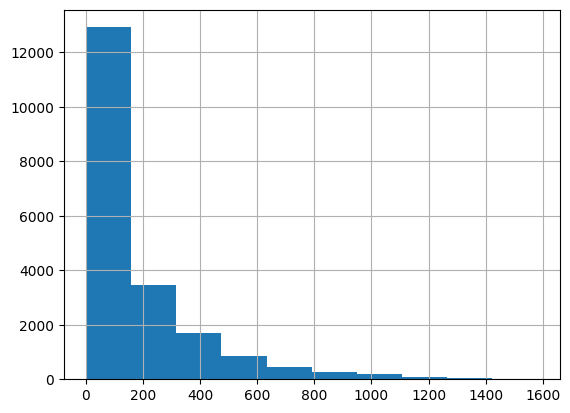

In [60]:
df['days_exposition'].hist();

Есть объявления которые продаются и более трех лет, но основная масса объявлений до 200 дней. Ознакомимся с ними более подробно попозже.  
Пропуски заполнять не будем, т.к. заполнить медианным или средним значением не совсем корректно. Мы не знаем от чего и как зависит длитильность продажи - от цены, месторасположения, площади и т.д. А скорее всего все эти признаки сильно влияют на скорость продажи.

Посмотрим нашу таблицу после всех преобразований.

In [61]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.600000,1,False,False,11.0,2.0,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.300000,4,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,89.231153,9,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [62]:
df.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.000000
floors_total            0.000000
living_area             0.000000
floor                   0.000000
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096303
balcony                 0.000000
locality_name           0.000000
airports_nearest        0.233520
cityCenters_nearest     0.232523
parks_around3000        0.232480
parks_nearest           0.659906
ponds_around3000        0.232480
ponds_nearest           0.616782
days_exposition         0.133793
dtype: float64

In [63]:
df.shape

(23073, 21)

*Все пропуски заполнены, кроме столбцов, в которых мы не нашли корректного способоа заполнения, который бы не исказил общую картину.*

*Напоминаю как мы заполняли пропуски:*
- *Высота потолка: медианным значением.*
- *Кол-во этажей в доме: квартиры до 9 этажа включительно - медианным значением 9. Все что выше - 25 этажом.*
- *Жилая площадь: линейным коэф. 0,56 умноженную на общую площадь.*
- *Балконы: нулем, предположили что балконов нет в этих квартирах.*
- *Название населённого пункта: удалили строки с пустыми значениями.*

*Так же был удален столбец 'апартаменты' из-за недостаточного количества данных.*

#### Типы данных

In [64]:
df.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Выполним следующие преобразования:
- last_price в int
- first_day_exposition в datetime
- floors_total в int
- balcony в int

In [65]:
df = df.astype({"last_price": int, "floors_total": int, "balcony": int})

In [66]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [67]:
df.dtypes

total_images                     int64
last_price                       int32
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int32
living_area                    float64
floor                            int64
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

Все типы исправлены. Столбец 'days_exposition' поменять не можем, потому что там есть пропуски с типом float.

#### Аномалии в данных

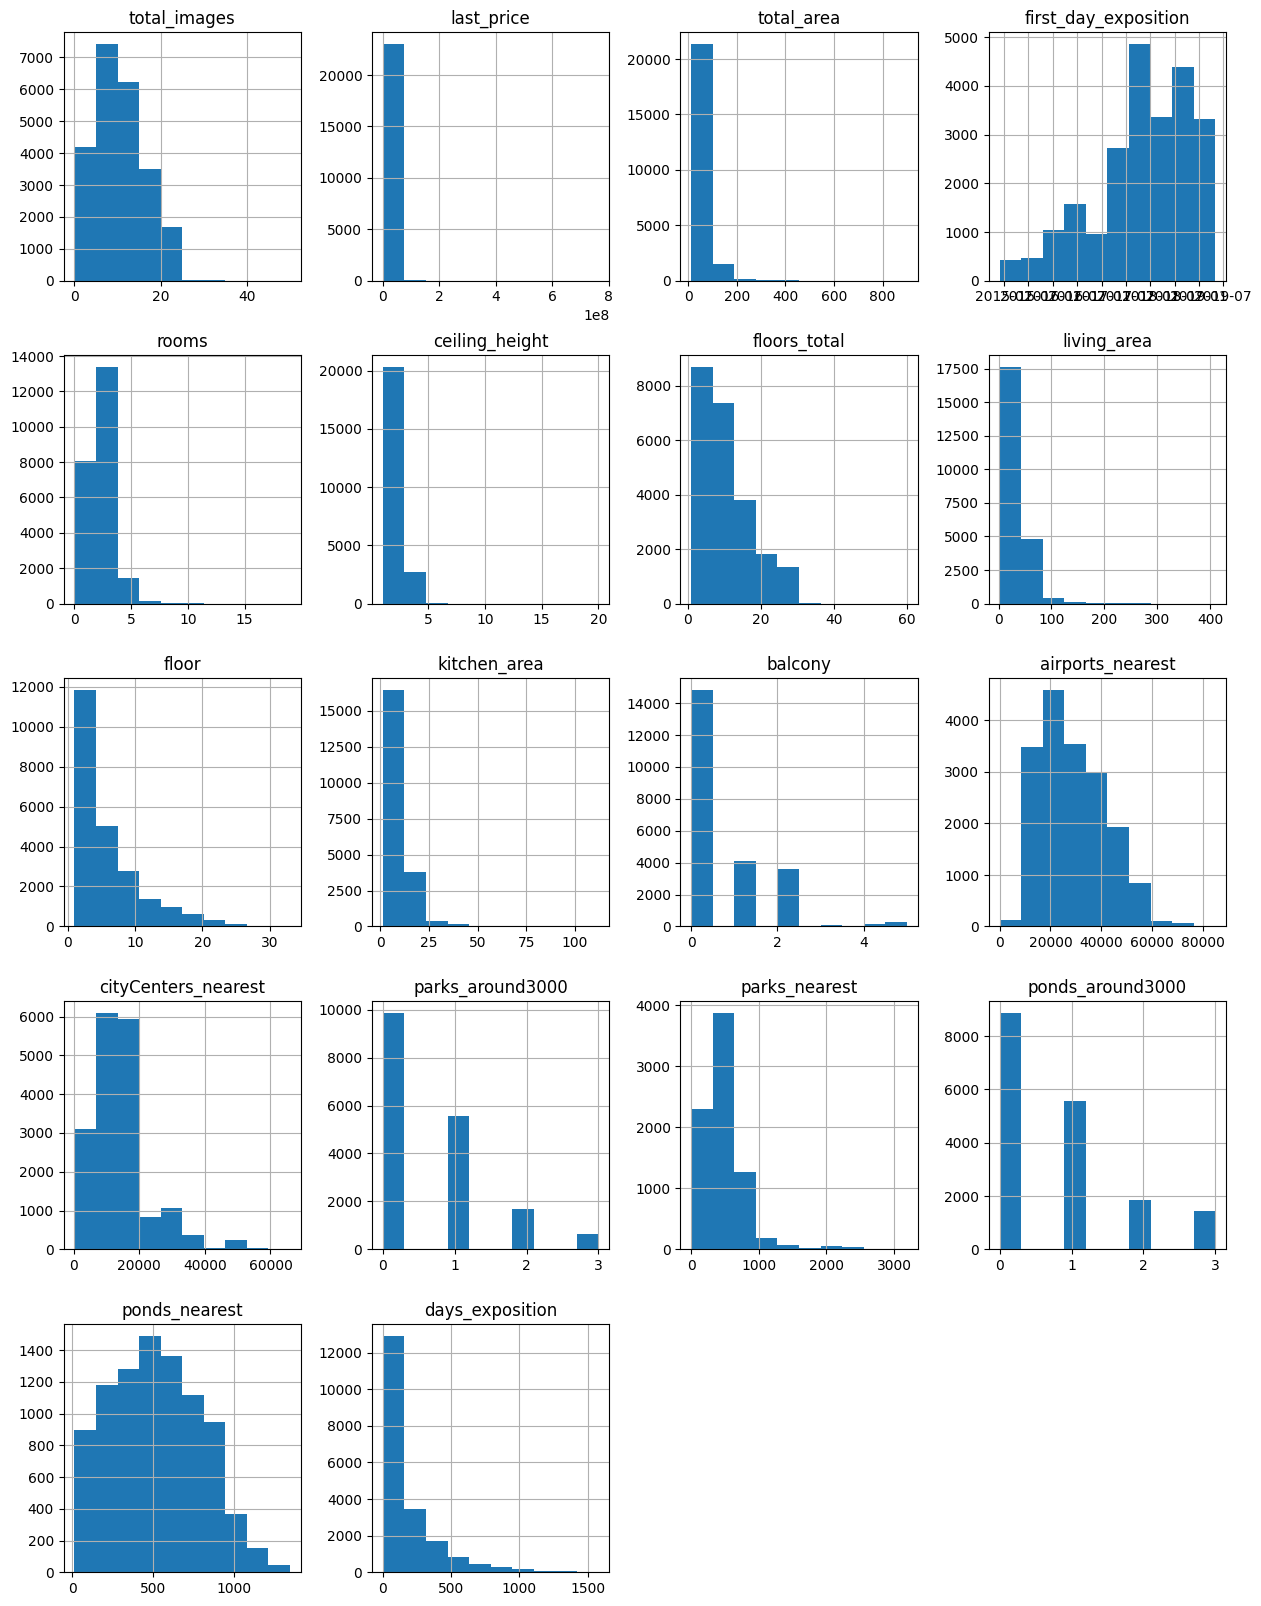

In [68]:
df.hist(figsize=(15, 20));

По гистограмам видно что практически в каждом столбце есть аномальные выбивающиеся значения, которые сильно отлчаются от других значений.  
"Хорошие" графики получились в столбцах 'first_day_exposition', в целом виден рост количества объявлений.  
Так же логично выглядят графики 'floors_total', 'floors' 'park_around3000' и 'ponds_around3000'.  
Посмотри подробно каждый столбец.

Прежде чем избавляться от аномалий, посмотрим сколько данных в нашем dataframe.

In [69]:
df.shape

(23073, 21)

(23585, 19)

**total_images**

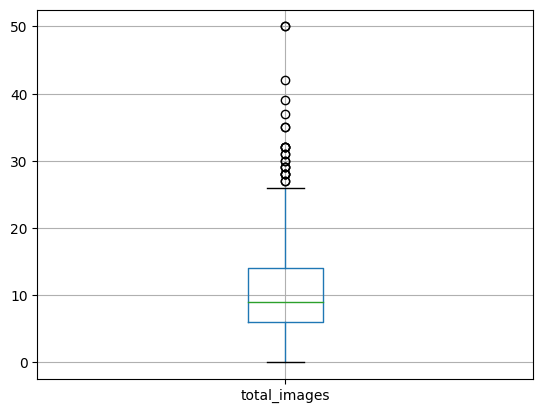

In [70]:
df.boxplot('total_images');

По графики не видно ничего удивительного. Медина находится на показателе 9-10 фотографий.  
Есть выбросы по 25 фотографий и выше, хотя на мой взглад, при продаже квартиры должно быть минимум 20 фотографий.  
Максимальное количество 50 фотографий. Не будем удалять никакие строки, потому что 50, что 30, что 10 вряд ли сильно повлияют на продажу, но зато вы оставим другие ценные данные, такие как цена, площадь и т.д.

**last_price**

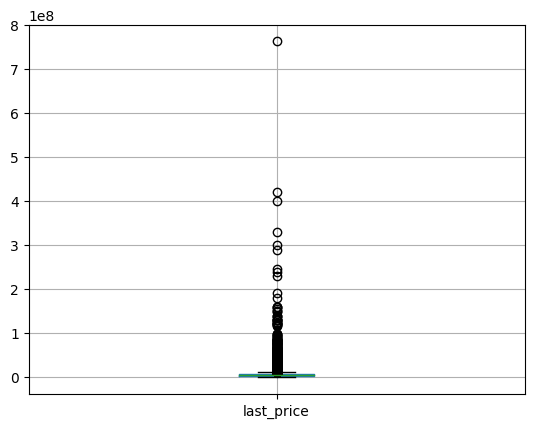

In [71]:
df.boxplot('last_price');

Здесь уже видны выбросы, которые сильно отличаются от основной массы. Давайте посмотрим первые 10 строк.

In [72]:
df.sort_values('last_price', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12971,19,763000000,400.0,2017-09-30,7,2.65,10,250.000000,10,False,False,NaN,2,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0
19540,8,420000000,900.0,2017-12-06,12,2.80,25,409.700000,25,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0
14706,15,401300000,401.0,2016-02-20,5,2.65,9,204.000000,9,False,False,24.0,3,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393.0
1436,19,330000000,190.0,2018-04-04,3,3.50,7,95.000000,5,False,False,40.0,0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0
15651,20,300000000,618.0,2017-12-18,7,3.40,7,258.000000,5,False,False,70.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0
22831,18,289238400,187.5,2019-03-19,2,3.37,6,63.700000,6,False,False,30.2,0,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN
16461,17,245000000,285.7,2017-04-10,6,3.35,7,182.800000,4,False,False,29.8,0,Санкт-Петербург,33143.0,6235.0,3.0,400.0,3.0,140.0,249.0
13749,7,240000000,410.0,2017-04-01,6,3.40,7,218.000000,7,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,199.0
5893,3,230000000,500.0,2017-05-31,6,2.65,7,280.601111,7,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0
8900,13,190870000,268.0,2016-03-25,3,2.65,8,132.000000,7,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,901.0


Квартира за 763млн руб выглядет очень странно. Конечно мы не можем утверждать что это ошибка в объявлении, например, просмотрев объявления которые сейчас выставлены на продажу, то там так же можно встретить квартиру за 900млн руб.
Построим немного другой график.

Еще раз внимательно посмотрим на график.

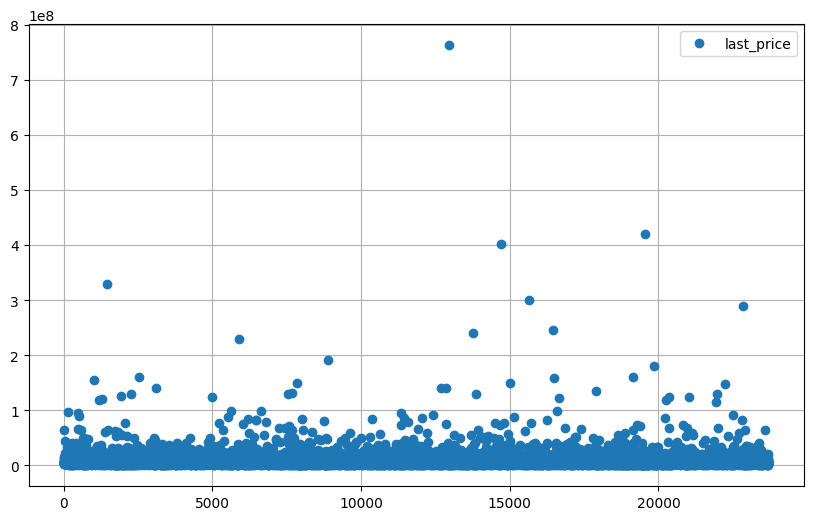

In [73]:
df.plot(y='last_price', style='o', figsize=(10,6), grid=True);

Здесь уже хорошо видно, что квартиры дороже 200млн руб встречаются совсем редко, выше 100млн тоже редко, но чуть чаще.  
Посмотрим сколько квартир выше 100млн руб.

In [74]:
df.query('last_price > 100000000').shape

(36, 21)

Всего 37 строчок, удалим эти данные так как они сильно не типичные и вносят шум в общую картину.

In [75]:
df = df.query('last_price < 100000000')

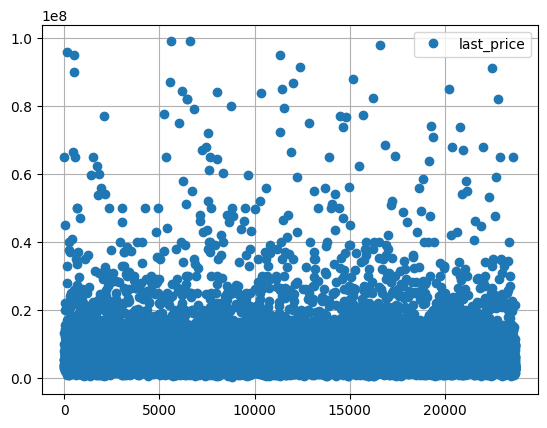

In [76]:
df.plot(y='last_price',style='o', grid=True);

Тут данные уже расположены более плотно.

Так же посмотрим что с квартирами с маленькой стоимостью.

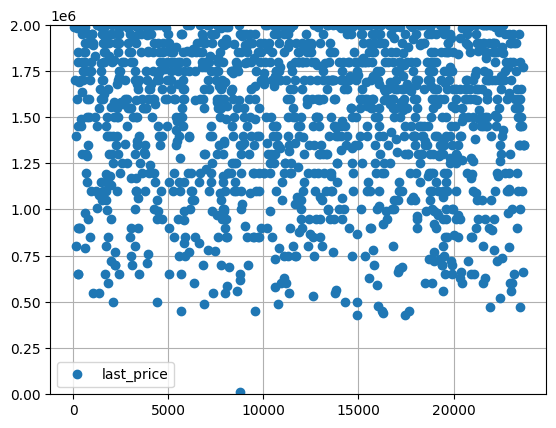

In [77]:
df.plot(y='last_price',style='o', grid=True, ylim=(0, 2000000));

Выбивается только один объект, остальные данные идут достаточно плотно, ограничим 500 000 руб.

In [78]:
df = df.query('last_price > 500000')

**total_area**

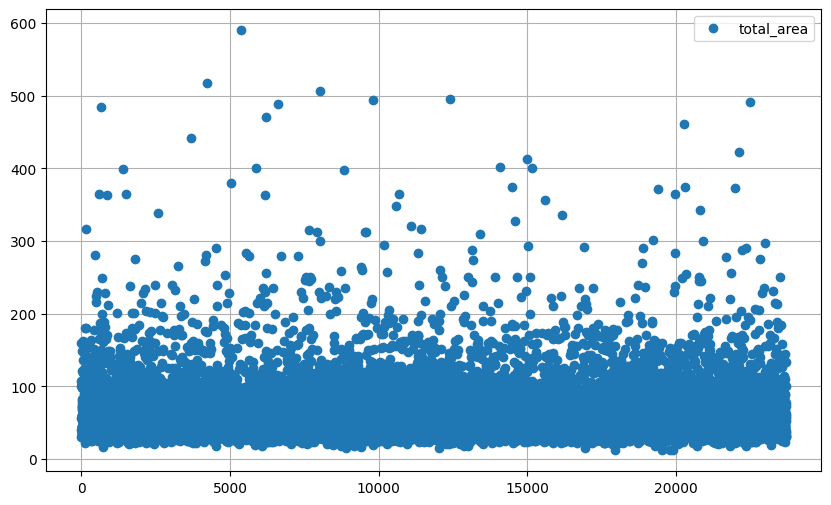

In [79]:
df.plot(y='total_area', style='o', figsize=(10,6), grid=True);

Исключим квартиры более 300м2.

In [80]:
df = df.query('total_area < 300')

**first_day_exposition**

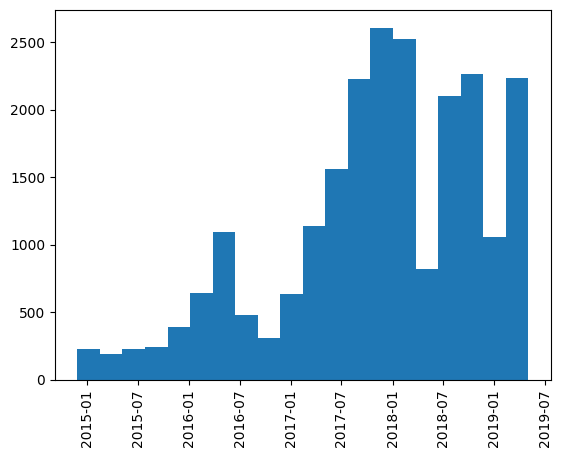

In [81]:
plt.hist(df['first_day_exposition'], bins=20)
plt.xticks(rotation='vertical')
plt.show()

В нашей базе присутствуют объявления с января 2015 года, по июль 2019. Объявлений за 2015 год не так много. 

In [82]:
len(df[df['first_day_exposition'].dt.year == 2015])

1134

In [83]:
len(df[df['first_day_exposition'].dt.year == 2015]) / len(df)

0.04936014625228519

Всего 5% из общего числа, наверно много было бы оставить объявление начиная с 2016 года, чтобы видеть актуальную стоимость, но пока оставим как есть.

**rooms**

In [84]:
df['rooms'].value_counts()

1     7853
2     7737
3     5629
4     1123
5      295
0      193
6       83
7       43
8        7
9        4
10       3
11       2
16       1
14       1
Name: rooms, dtype: int64

Удалим квартиры с 8 и более комнатами.

In [85]:
df = df[df['rooms'] <= 7]

**ceiling_height**

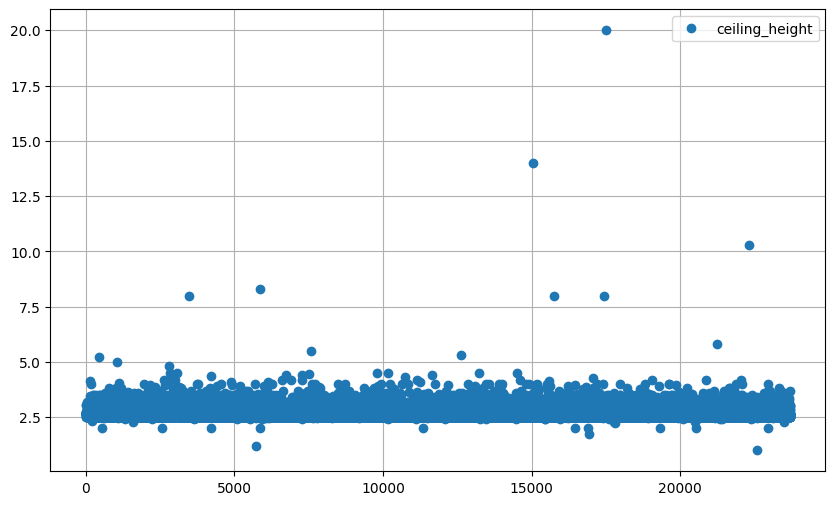

In [86]:
df.plot(y='ceiling_height', style='o', figsize=(10,6), grid=True);

Оставим квартиры с потолками выше 2,4м и ниже 5м

In [87]:
df = df[(df['ceiling_height'] >= 2.4) & (df['ceiling_height'] <= 5)]

**floors_total**

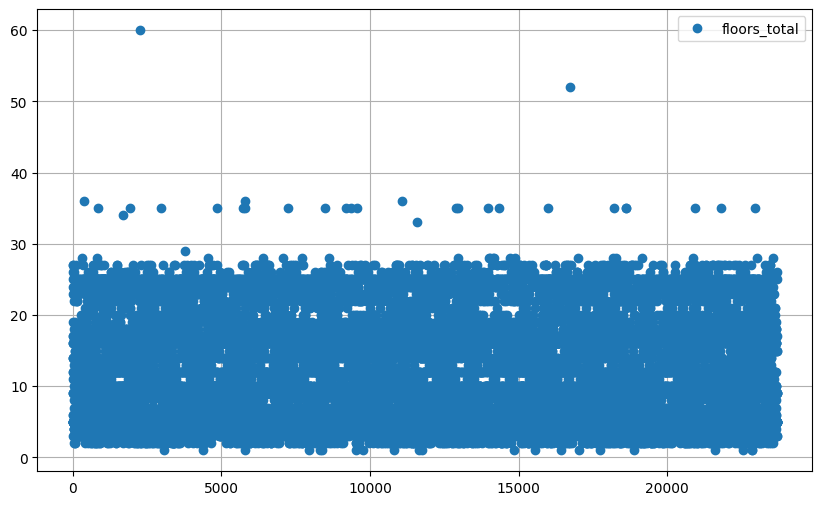

In [88]:
df.plot(y='floors_total', style='o', figsize=(10,6), grid=True);

По данным которые нашел в интеренте, самый высокий жилой дом в СПБ - 37 этажей, что в целом подтверждает линия, которая проходит чуть ниже 40 этажа. Поэтому удалим дома с этажом выше 37.

In [89]:
df = df[df['floors_total'] <= 37]

**floor**

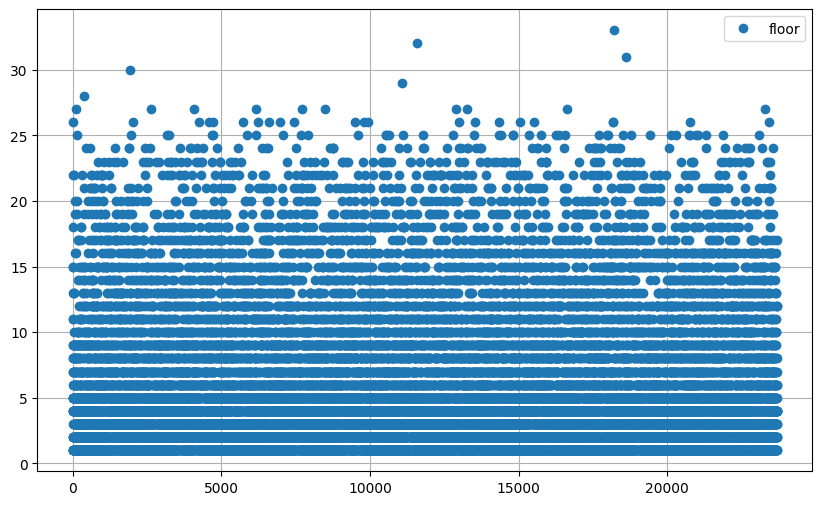

In [90]:
df.plot(y='floor', style='o', figsize=(10,6), grid=True);

Аномалий по этажу нет, только выполним проверку, чтобы этаж не больше всех этажей в доме.

In [91]:
(df['floor'] > df['floors_total']).sum()

0

Таких обхъявлений нет, отлично.

**studio**

In [92]:
df['studio'].value_counts()

False    22779
True       145
Name: studio, dtype: int64

Всего 148 студий, конечно навряд ли они нам что-то дадут, оставим без изменений.

**open_plan**

In [93]:
df['open_plan'].value_counts()

False    22858
True        66
Name: open_plan, dtype: int64

Здесь еще меньше, этот столбец нам точно не понадобится, удалим его.

In [94]:
df = df.drop(['open_plan'], axis='columns')

**kitchen_area**

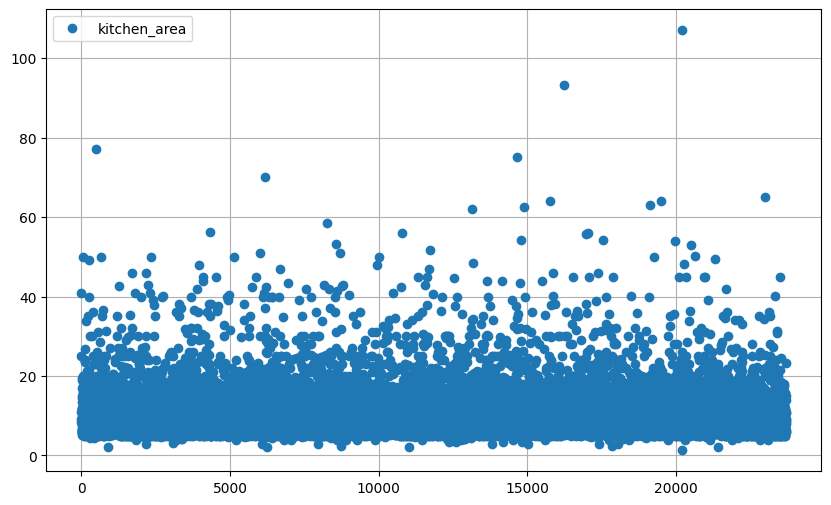

In [95]:
df.plot(y='kitchen_area', style='o', figsize=(10,6), grid=True);

Оставим квартиры с площадью кухни до 60м2.

In [96]:
df = df[(df['kitchen_area'].isna() == True) | (df['kitchen_area'] < 60)]

**balcony**

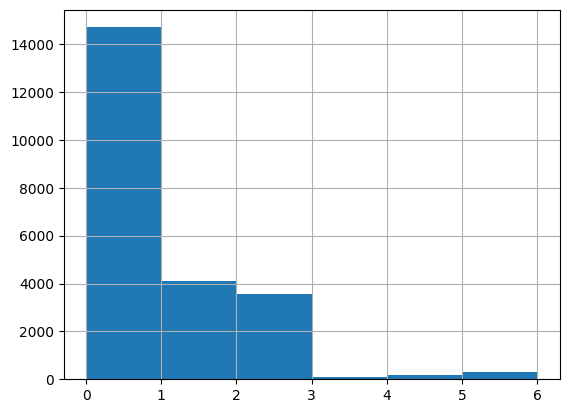

In [97]:
df['balcony'].hist(bins=6, range=(0,6));

Количество балконов мало на что влияет, оставим как есть. Так же не забываем что большее количество квартир без балконов связвно с тем, что мы заполнили отсутствующие значения нулями.

**airports_nearest  
cityCenters_nearest  
parks_around3000  
ponds_around3000**

In [98]:
t = df.loc[:, 'airports_nearest': 'ponds_around3000']

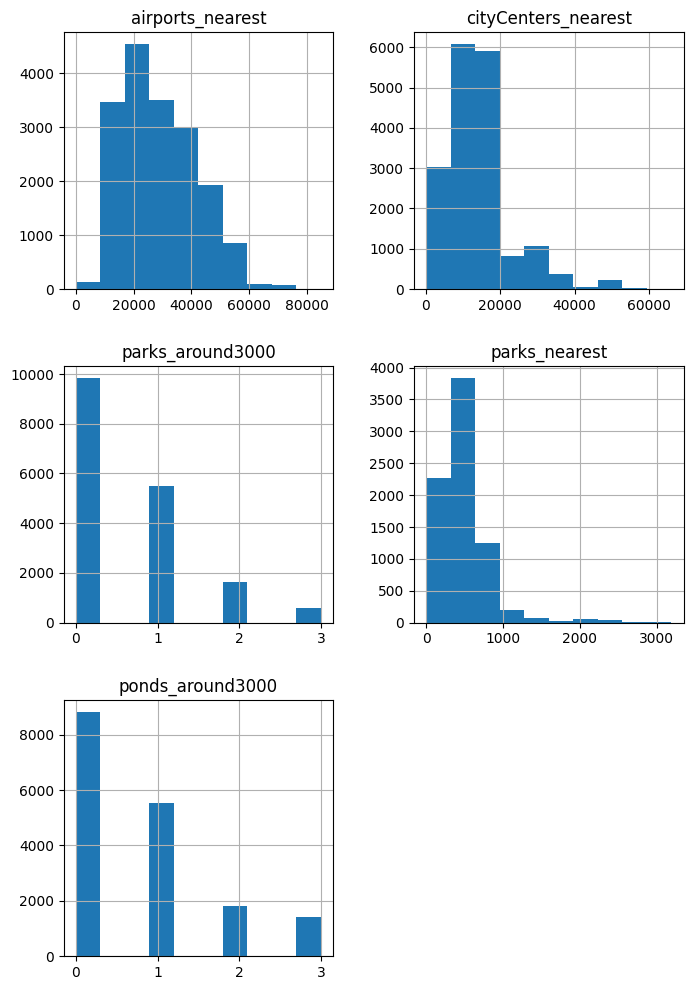

In [99]:
t.hist(figsize=(8, 12));

Оставим данные как есть.

**days_exposition**

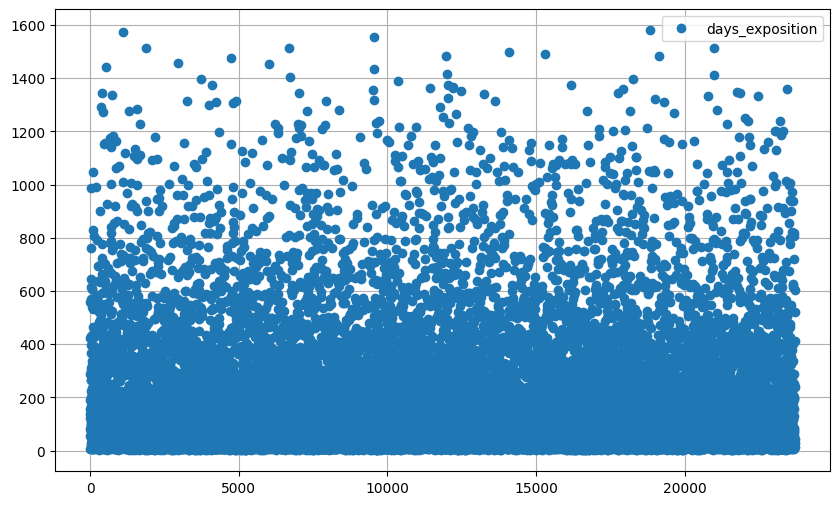

In [100]:
df.plot(y='days_exposition', style='o', figsize=(10,6), grid=True);

Есть квартиры более которые продавлись более 3-4х лет. Непонятно почему это производило и по какой причине их продали. Например, передумали или в итоге снизили цену и продали.  
Оставим данные без изменения.




*Мы отфильтровали и оставили следующие квартиры:*  
- *стоимостью от 500К до 100млн руб.*
- *площадью до 300м2.*
- *до 7 комнат включительно.*
- *с потолками от 2,4 до 5м.*
- *общем количеством - до 37 включительно.*
- *удалили данные о свободных планировках, т.к. столбец не нес никакой информации.*

Проверим аномалии в столбцах 'total_area', 'ceiling_height', 'days_exposition',   'living_area',  'kitchen_area' 

**total_area**

В столбце 'total_area' удалим все квартиры более менее 20м2 и более 250м2.

In [101]:
df = df[(df['total_area'] >= 20) & (df['total_area'] <= 250)]

**ceiling_height**

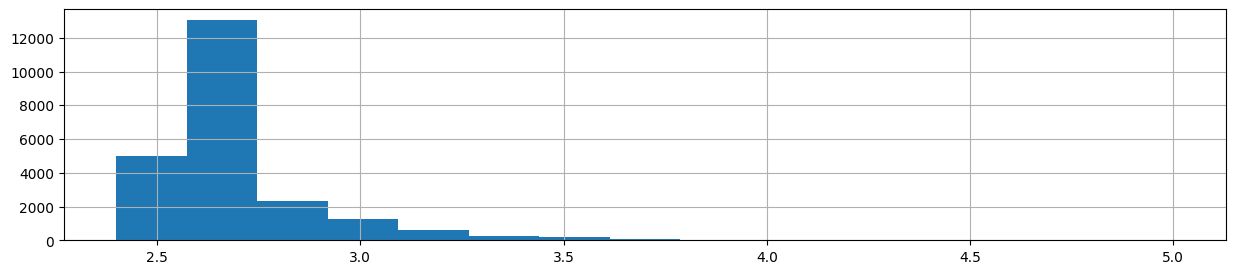

In [102]:
df['ceiling_height'].hist(bins = 15, figsize = (15,3));

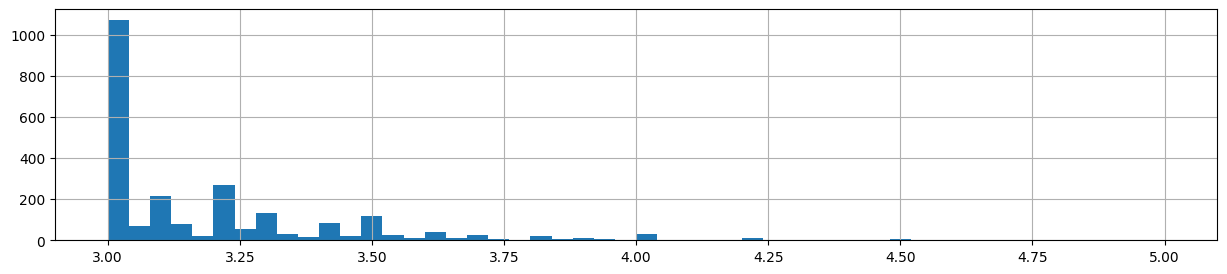

In [103]:
df['ceiling_height'].hist(bins = 50, figsize = (15,3), range=(3, 5));

Отфильтруем все квартиры выше 3,5м.

In [104]:
df = df[df['ceiling_height'] <= 3.5]

In [105]:
df.shape

(22627, 20)

**days_exposition**

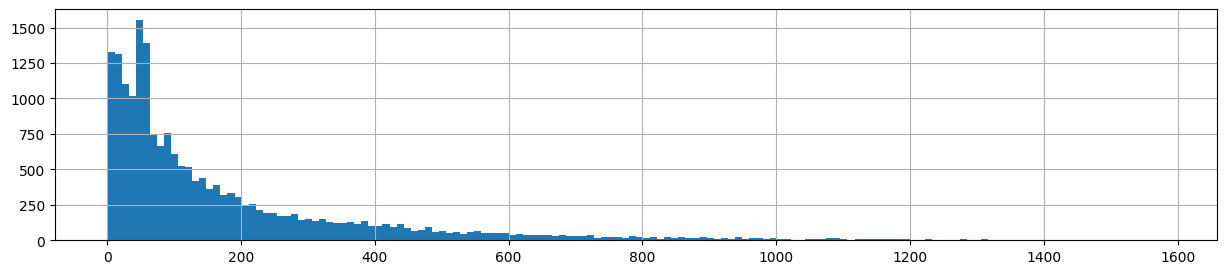

In [106]:
df['days_exposition'].hist(bins = 150, figsize = (15,3));

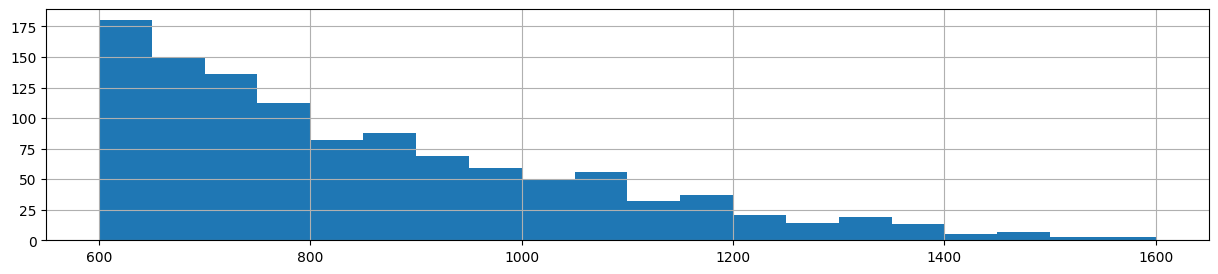

In [107]:
df['days_exposition'].hist(bins = 20, figsize = (15,3), range=(600,1600));

Отфильтруем все квартиры которые продовались дольше 1200 дней.

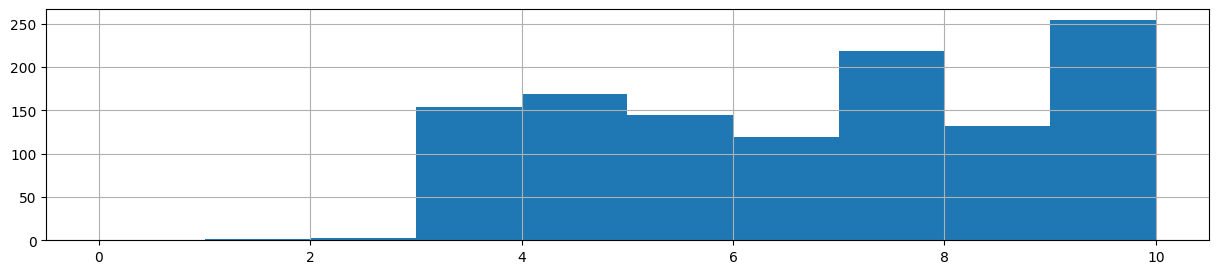

In [108]:
df['days_exposition'].hist(bins = 10, figsize = (15,3), range=(0,10));

По нижней границе удалим объявления, обпубликованные меньше 3х дней.

In [109]:
df = df[(df['days_exposition'].isna() == True) | ((df['days_exposition'] >= 3) & (df['days_exposition'] <= 1200))]

**living_area**

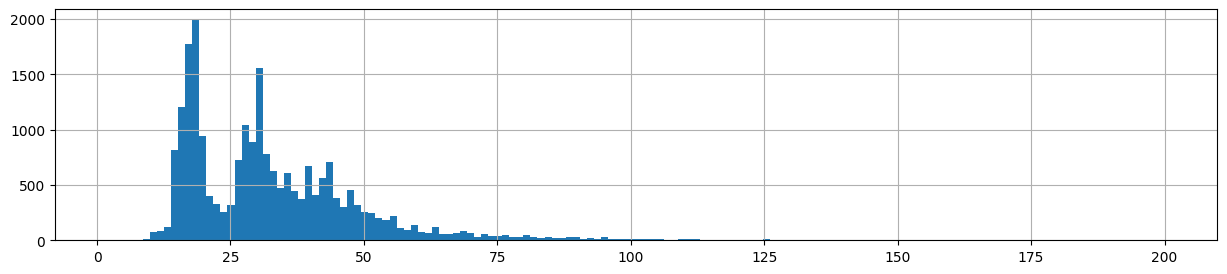

In [110]:
df['living_area'].hist(bins = 150, figsize = (15,3));

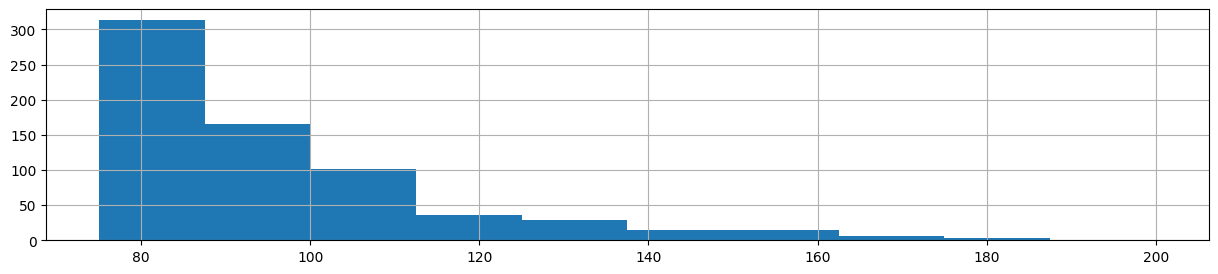

In [111]:
df['living_area'].hist(bins = 10, figsize = (15,3), range=(75,200));

Отфильтруем все квартиры с жилой площадью более 110 м2.

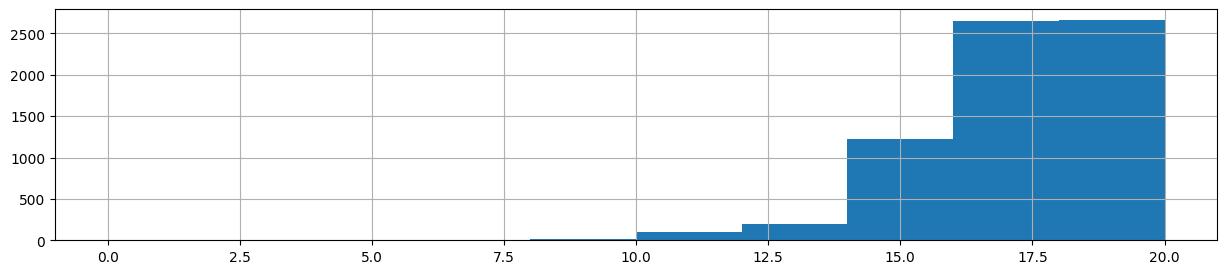

In [112]:
df['living_area'].hist(bins = 10, figsize = (15,3), range=(0,20));

Отфильтруем все квартиры с жилой площадью менее 12.5 м2.

In [113]:
df = df[(df['living_area'].isna() == True) | ((df['living_area'] >= 12.5) & (df['living_area'] <= 110))]

**kitchen_area**

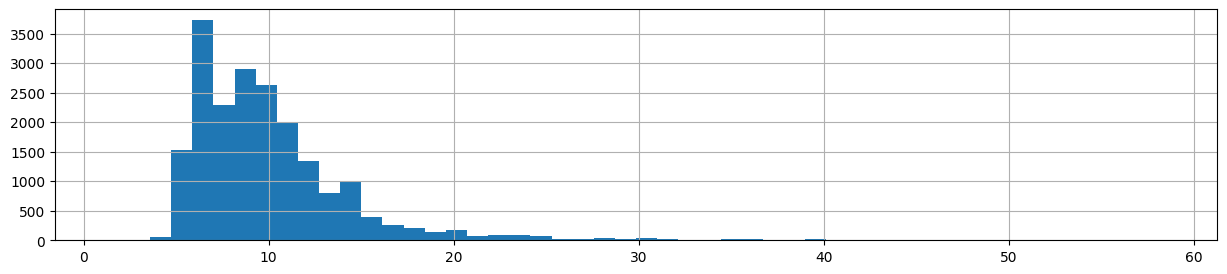

In [114]:
df['kitchen_area'].hist(bins = 50, figsize = (15,3));

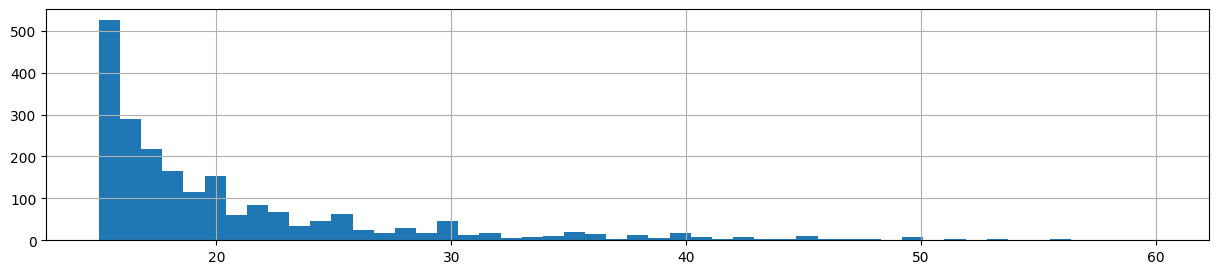

In [115]:
df['kitchen_area'].hist(bins = 50, figsize = (15,3), range=(15,60));

Отфильтруем все квартиры с площадью кухни более 25 м2.

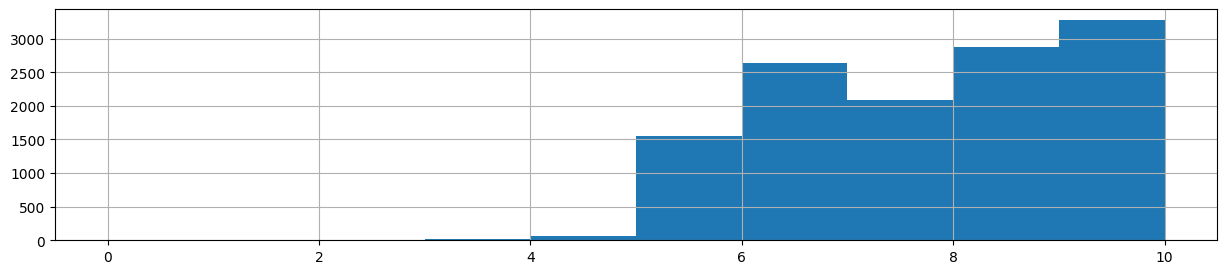

In [116]:
df['kitchen_area'].hist(bins = 10, figsize = (15,3), range=(0,10));

Отфильтруем все квартиры с площадью кухни менее 5 м2.

In [117]:
df = df[(df['kitchen_area'].isna() == True) | ((df['kitchen_area'] >= 5) & (df['kitchen_area'] <= 25))]

In [118]:
df.shape

(21811, 20)

*Мы отфильтровали и оставили следующие квартиры:*  
- *стоимостью от 500К до 100млн руб.*
- *до 7 комнат включительно.*
- *до 37 этажей включительно.*
- *с потолками от 2,4 до 3,5м включительно.**
- *время размещения которых составлял от 3 до 1200 дней включительно*
- *общей площадью от 20 до 250м2.*
- *жилой площадью от 12,5 до 110 м2.*
- *площадью кухни от 5 до 25 м2.*
- *удалили данные о свободных планировках, т.к. столбец не нес никакой информации.*  

В результате у нас осталось 21812 строк, то есть мы удалили около 8% от исходных данных.

### Посчитайте и добавьте в таблицу новые столбцы

Добавим в нашу таблцу некоторые столбцы, которые помогут нам при анализе.

**price_per_meter (цена за 1 квадратный метр)**  

Для решения этой задачи разделим цену на общую площадь.

In [119]:
df['price_per_meter'] = df['last_price'] / df['total_area']

Далее округлим и переведем число в целое значение.

In [120]:
df['price_per_meter'] = df['price_per_meter'].round(0)

In [121]:
df['price_per_meter'] = df['price_per_meter'].astype(int)

**weekday_publication (день публикации объявления)**  
**month_publication (месяц публикации объявления)**  
**year_publication (год публикации объявления)**

Для решения этой задачи воспользуемся функуциями dt.dayofweek; dt.month; dt.year

In [122]:
df['weekday_publication'] = df['first_day_exposition'].dt.dayofweek

In [123]:
df['month_publication'] = df['first_day_exposition'].dt.month

In [124]:
df['year_publication'] = df['first_day_exposition'].dt.year

**floor_type(тип этажа квартиры)**

Сгруппируем квартиры по этажу на 3 три типа:
- первый
- последний
- другой

In [125]:

def categorize_floor(row):
    floor = row['floor']
    total_floors = row['floors_total']
    
    if floor == 1:
        return 'первый'
    if floor == total_floors:
        return 'последний'
    elif floor <= 0:
        return 'ошибка в данных, перепроверить этаж'
    else:
        return 'другой'

Сделали функцию, которая будет присваивать категорию в зависимости от этажа и применим ее к нашему dataframe.

In [126]:
df['floor_type'] = df.apply(categorize_floor, axis=1)

**cityCenters_nearest_km(расстояние в км до центра города)**

Раздели столбец cityCenters_nearest на 1000 и округлим до целых значений.

In [127]:
df['Centers_nearest_km'] = df['cityCenters_nearest'] / 1000

In [128]:
df['Centers_nearest_km'] = df['Centers_nearest_km'].round(0)

*Посмотрим на получившиеся данные.*

In [129]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday_publication,month_publication,year_publication,floor_type,Centers_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82921,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92786,3,8,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,89.231153,9,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176,4,7,2015,другой,7.0
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.400000,5,False,9.1,0,поселок городского типа Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95066,0,9,2018,другой,NaN


### Проведите исследовательский анализ данных

#### Изучение основных параметров

Изучим следующие столбцы:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;

Для анализа количественных переменных отлично подойдет функция describe.

In [130]:
table_for_analysis = df[['total_area', 'living_area','kitchen_area','last_price', \
                          'rooms','ceiling_height','floor','floors_total','cityCenters_nearest', \
                          'airports_nearest','parks_nearest']]


In [131]:
pd.options.display.float_format ='{:,.2f}'.format
table_for_analysis.describe().T

,count,mean,std,min,25%,50%,75%,max
total_area,"21,811.00",56.66,23.93,20.00,40.00,51.00,67.00,236.00
living_area,"21,811.00",32.39,15.58,12.50,18.80,30.00,41.00,110.00
kitchen_area,"19,701.00",9.75,3.58,5.00,7.00,9.00,11.30,25.00
last_price,"21,811.00","5,655,077.27","4,638,682.65","520,000.00","3,400,000.00","4,550,000.00","6,450,000.00","98,000,000.00"
rooms,"21,811.00",2.01,0.96,0.00,1.00,2.00,3.00,7.00
ceiling_height,"21,811.00",2.68,0.17,2.40,2.60,2.65,2.70,3.50
floor,"21,811.00",5.92,4.88,1.00,2.00,4.00,8.00,33.00
floors_total,"21,811.00",10.81,6.58,1.00,5.00,9.00,16.00,36.00
cityCenters_nearest,"16,610.00","14,549.54","8,493.39",181.00,"9,937.50","13,300.00","16,460.25","65,968.00"
airports_nearest,"16,590.00","28,873.00","12,771.50",0.00,"18,344.25","27,059.00","37,434.00","84,869.00"


По этой таблице нам видны:
* общая выборка для каждого показтеля (count)
* среднее арифметическое значение (mean)
* насколько в среднем каждое значение отклоняется в среднего арифмететического значания (std)
* минимальные и максимальные значание (min, max)
* мединные значения (25%, 50% 75%)

In [132]:
df['floor_type'].value_counts(normalize=True)

другой      0.74
последний   0.14
первый      0.12
Name: floor_type, dtype: float64

Распределение по этажам следующее:
- 12% квартир расположены на 1 этаже
- 14% квартир на последнем
- 74% на всех других

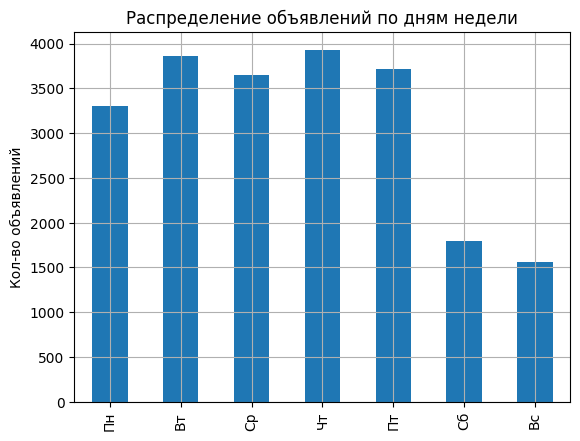

In [133]:
df['weekday_publication'].value_counts(sort=False).plot.bar(grid=True);
plt.ylabel('Кол-во объявлений');
plt.title('Распределение объявлений по дням недели');
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Пн', 'Вт', 'Ср','Чт','Пт','Сб','Вс']);

По графику видно, что в выходные люди размещают объявления в два раза меньше, чем в будни.  
Возможно это связано с тем, что в будни размещением объявлений занимаются риэлторские агенства. 

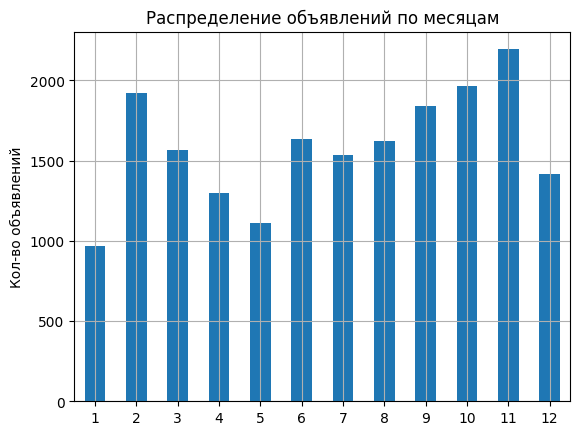

In [134]:
df.query('(year_publication > 2014) and (year_publication < 2019)')['month_publication'] \
    .value_counts(sort=False) \
    .plot(kind='bar', grid=True, rot=0);
plt.ylabel('Кол-во объявлений');
plt.title('Распределение объявлений по месяцам');

Исключили из графика неполные года - 2014, 2019.  
Больше всего объявлений публикуют осенью. 
Непонятно чем можно вызван всплекс в феврале, т.к. там меньше дней и много праздников, по логике кол-во объявлений не должно превышать показателя марта.


Выведем основные параметры по исследуемым столбцам.

In [135]:
(
    df[['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 
          'ceiling_height',  'floor', 'floors_total', 'cityCenters_nearest', 'airports_nearest', 'parks_nearest']]
        .apply (['median', 'mean'])   
        .style.format("{:,.1f}")
)

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floor,floors_total,cityCenters_nearest,airports_nearest,parks_nearest
median,51.0,30.0,9.0,"4,550,000.0",2.0,2.6,4.0,9.0,"13,300.0","27,059.0",456.0
mean,56.7,32.4,9.8,"5,655,077.3",2.0,2.7,5.9,10.8,"14,549.5","28,873.0",493.5


**total_area**

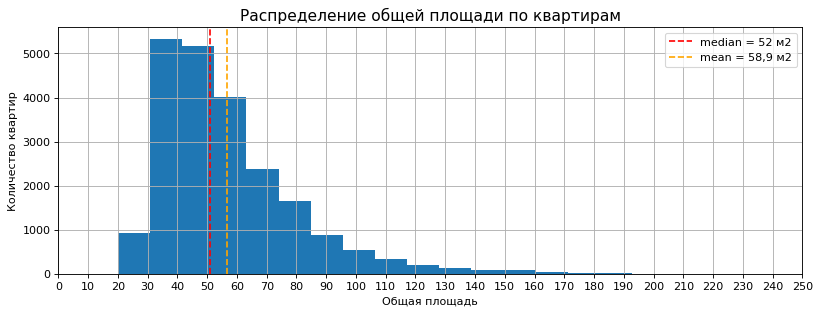

In [136]:
figure(figsize=(12, 4), dpi=80)

plt.hist(df['total_area'], bins=20);
plt.axvline(df['total_area'].median(), color='r', linestyle='--', label='median = 52 м2');
plt.axvline(df['total_area'].mean(), color='orange', linestyle='--', label='mean = 58,9 м2');
plt.title('Распределение общей площади по квартирам', fontsize=14);
plt.xlabel('Общая площадь');
plt.ylabel('Количество квартир');
plt.xticks(np.arange(0, 260, step=10));
plt.grid(True)
plt.legend();

Наиболее распространенными являются квартиры от 30 до 50 м2. И далее чем выше площадь, тем реже встрается эта кваритры.
Средняя площадь всех квартир составляет 58,9 м2, связано с тем, на рынки приствуют квартиры с довольно бльшими площадями - более 100м2.

**living_area**

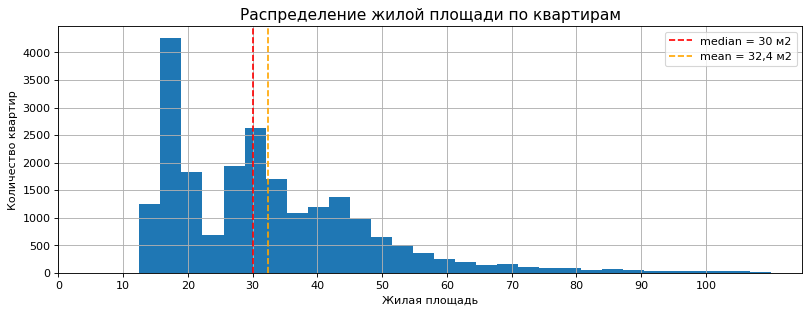

In [137]:
figure(figsize=(12, 4), dpi=80)

plt.hist(df['living_area'], bins=30);
plt.axvline(df['living_area'].median(), color='r', linestyle='--', label='median = 30 м2');
plt.axvline(df['living_area'].mean(), color='orange', linestyle='--', label='mean = 32,4 м2');
plt.title('Распределение жилой площади по квартирам', fontsize=14);
plt.xlabel('Жилая площадь');
plt.ylabel('Количество квартир');
plt.xticks(np.arange(0, 110, step=10));
plt.grid(True)
plt.legend();

В значениях между 20 и 30 м2 присутствует провал в площади, сложно его чем-то объяснить. Очень популярны жилые площади около 18 м2 и 30 м2, далее с ростом жилой площади уменьшается и кол-во квартир.  
Средняя жилая площадь = 32,4 м2.

**kitchen_area**

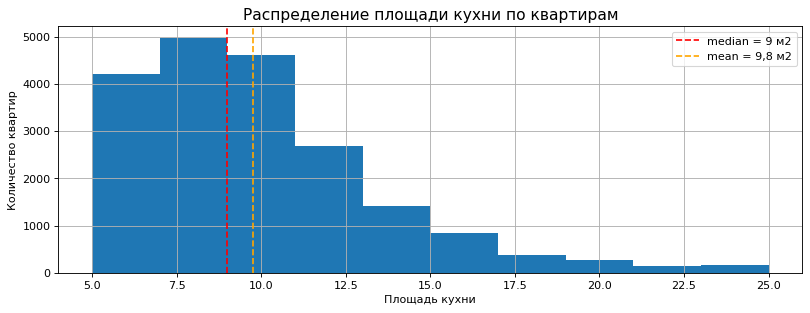

In [138]:
figure(figsize=(12, 4), dpi=80)

plt.hist(df['kitchen_area'], bins=10);
plt.axvline(df['kitchen_area'].median(), color='r', linestyle='--', label='median = 9 м2');
plt.axvline(df['kitchen_area'].mean(), color='orange', linestyle='--', label='mean = 9,8 м2');
plt.title('Распределение площади кухни по квартирам', fontsize=14);
plt.xlabel( 'Площадь кухни');
plt.ylabel('Количество квартир');
#plt.xticks(np.arange(0, 25, step=1));
plt.grid(True)
plt.legend();

Самы популярные площади кухни оть 6 до 11 м2. Для площаи идут на спад.  
Средняя площадь кухни по всем квартирам - 9м2.

**last_price**

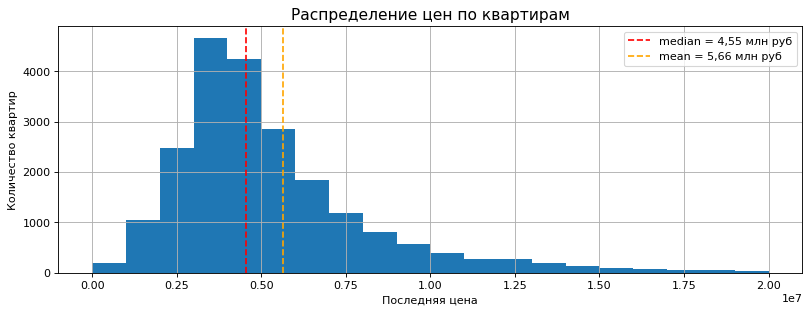

In [139]:
figure(figsize=(12, 4), dpi=80)

plt.hist(df['last_price'], bins=20, range=(0,20000000));
plt.axvline(df['last_price'].median(), color='r', linestyle='--', label='median = 4,55 млн руб');
plt.axvline(df['last_price'].mean(), color='orange', linestyle='--', label='mean = 5,66 млн руб');
plt.title('Распределение цен по квартирам', fontsize=14);
plt.xlabel( 'Последняя цена');
plt.ylabel('Количество квартир');
#plt.xticks(np.arange(0, 25, step=1));
plt.grid(True)
plt.legend();

На график вывели гистограмму для квартир до 20 млн руб, т.к. квартиры более 20 млн встречаются гораздо реже чем основная масса квартир и чем дороже, тем меньше квартир с такой ценой в продаже.  
Наиболее распространными являются квартиры стоимостью 2,5-5 млн руб.  
Средняя цена за квартиру - 5,66 млн руб.

**rooms**

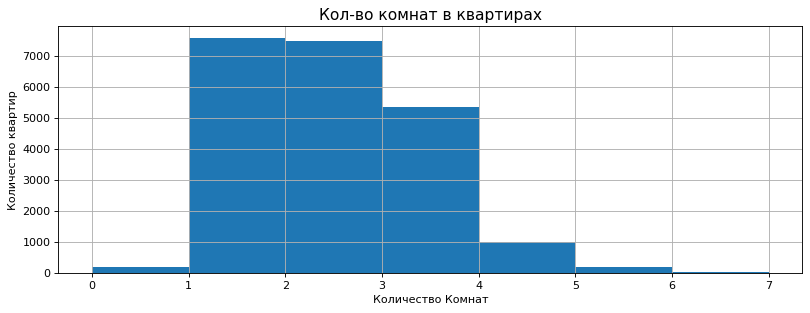

In [140]:
figure(figsize=(12, 4), dpi=80)

plt.hist(df['rooms'], bins=7);
plt.title('Кол-во комнат в квартирах', fontsize=14);
plt.xlabel('Количество Комнат');
plt.ylabel('Количество квартир');
plt.grid(True)

В продаже однокомнатных и двухкомнатных примерно одинаковое количество. Квартиры с 4 комнатами и больше встречаются достаточно редко. Так же на гистограмме присутствуют квартиры с 0 комнатами, это квартиры-студии, они встречаются очень редко.

**ceiling_height**

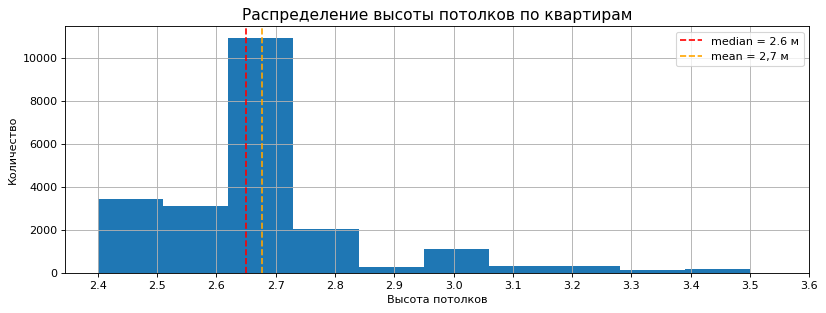

In [141]:
figure(figsize=(12, 4), dpi=80)

plt.hist(df['ceiling_height'], bins=10);
plt.axvline(df['ceiling_height'].median(), color='r', linestyle='--', label='median = 2.6 м');
plt.axvline(df['ceiling_height'].mean(), color='orange', linestyle='--', label='mean = 2,7 м');
plt.title('Распределение высоты потолков по квартирам', fontsize=14);
plt.xlabel('Высота потолков');
plt.ylabel('Количество');
plt.xticks(np.arange(2.4, 3.6, step=0.1));
plt.grid(True)
plt.legend();

Большая часть квартир имеют потолки 2,6-2.7. Потолки высотой более 2,7 встречаются довольно редко.

**floor**

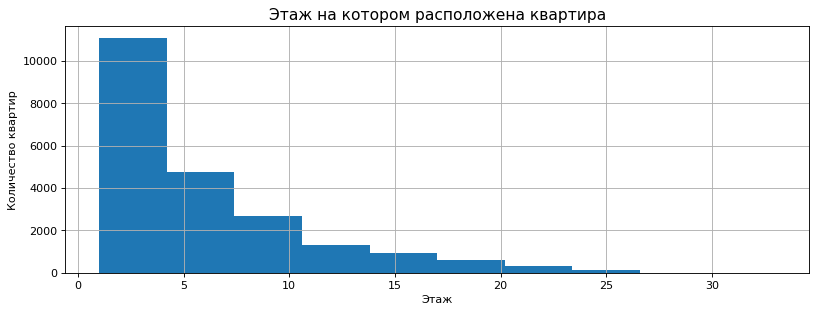

In [142]:
figure(figsize=(12, 4), dpi=80)

plt.hist(df['floor'], bins=10);
plt.title('Этаж на котором расположена квартира', fontsize=14);
plt.xlabel('Этаж');
plt.ylabel('Количество квартир');
plt.grid(True)

С ростом этажа уменьшается и кол-во квартир, находящихся на этом этаже. Это связано с типом домов. Например, в СПБ было просторено более 2000 "хрущевок", чаще всего этажность которых составляет 4-5 этажей.

**floor_type**

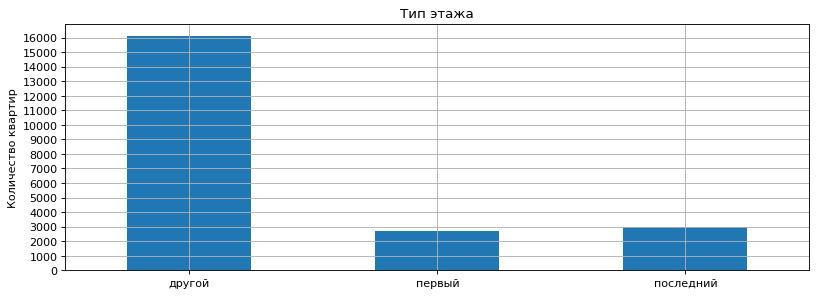

In [143]:
figure(figsize=(12, 4), dpi=80)

plt.title('Тип этажа на котором расположена квартира', fontsize=14);

df['floor_type'].value_counts(sort=False).plot.bar(grid=True);
plt.ylabel('Количество квартир');
plt.title('Тип этажа');
plt.yticks(np.arange(0, 16500, step=1000));
plt.xticks(rotation=0);

На первом и последнем этаже примерно одинаковое количество квартир.  
Самое больше количество квартир на все других этажах, примерно в 5,3 раза больше чем на первом.

**floors_total**

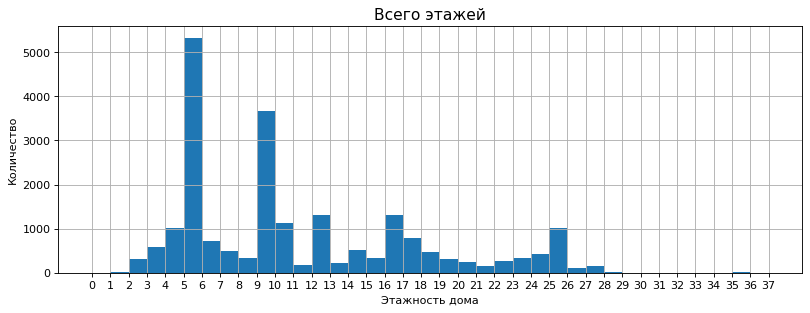

In [144]:
figure(figsize=(12, 4), dpi=80)

plt.hist(df['floors_total'], bins=(37), range=(0,37));
plt.title('Всего этажей', fontsize=14);
plt.xlabel('Этажность дома');
plt.ylabel('Количество');
plt.xticks(np.arange(0, 38, step=1));
plt.grid(True)

Больше всего в продаже 5-ти и 9-ти этажек. Вероятно это "хрущевки" и "панельки".

**cityCenters_nearest**

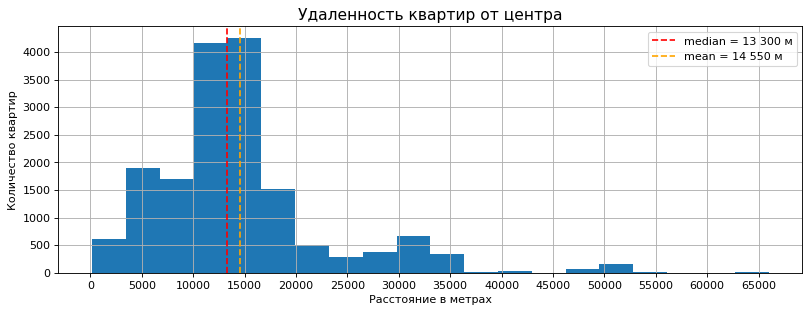

In [145]:
figure(figsize=(12, 4), dpi=80)

plt.hist(df['cityCenters_nearest'], bins=20);
plt.axvline(df['cityCenters_nearest'].median(), color='r', linestyle='--', label='median = 13 300 м');
plt.axvline(df['cityCenters_nearest'].mean(), color='orange', linestyle='--', label='mean = 14 550 м');
plt.title('Удаленность квартир от центра', fontsize=14);
plt.xlabel('Расстояние в метрах');
plt.ylabel('Количество квартир');
plt.xticks(np.arange(0, 70000, step=5000));
plt.grid(True)
plt.legend();

Большая часть квартир находится на удалении 10000-16000м от центра. В среднем квартиры удалены на 14 550м.

**airports_nearest**

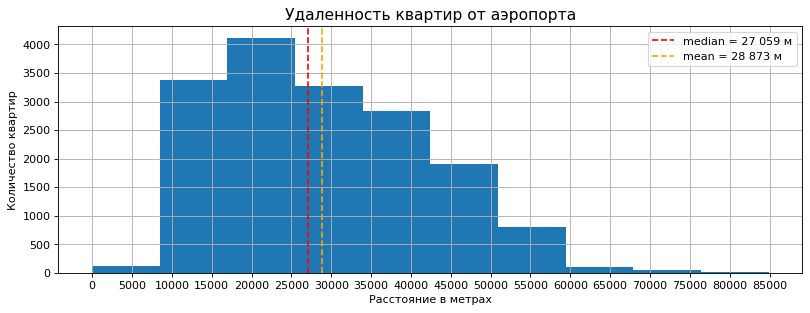

In [146]:
figure(figsize=(12, 4), dpi=80)

plt.hist(df['airports_nearest'], bins=10);
plt.axvline(df['airports_nearest'].median(), color='r', linestyle='--', label='median = 27 059 м');
plt.axvline(df['airports_nearest'].mean(), color='orange', linestyle='--', label='mean = 28 873 м');
plt.title('Удаленность квартир от аэропорта', fontsize=14);
plt.xlabel('Расстояние в метрах');
plt.ylabel('Количество квартир');
plt.xticks(np.arange(0, 90000, step=5000));
plt.grid(True)
plt.legend();

Практически все квартиры на которые у нас есть данные расположены на удалении 8-60 км от аэропорта, большая часть которых от 16 до 25 км.

**parks_nearest**

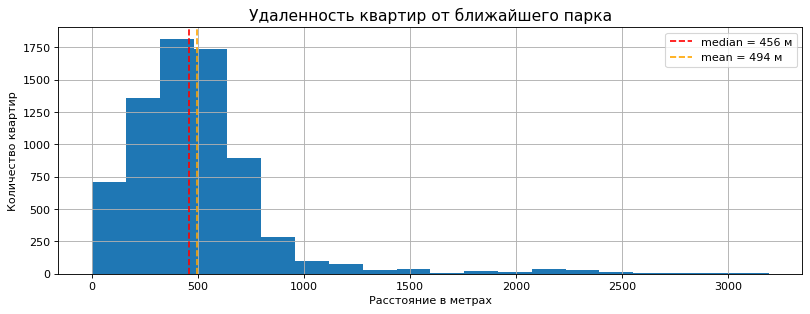

In [147]:
figure(figsize=(12, 4), dpi=80)

plt.hist(df['parks_nearest'], bins=20);
plt.axvline(df['parks_nearest'].median(), color='r', linestyle='--', label='median = 456 м');
plt.axvline(df['parks_nearest'].mean(), color='orange', linestyle='--', label='mean = 494 м');
plt.title('Удаленность квартир от ближайшего парка', fontsize=14);
plt.xlabel('Расстояние в метрах');
plt.ylabel('Количество квартир');
#plt.xticks(np.arange(0, 90000, step=5000));
plt.grid(True)
plt.legend();

Основная масса квартир на которые у нас есть данные расположены достаточно близко к паркам - в пределах 1км. Среднее расстояние составляет 494м.

#### Задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). 

In [148]:
df['days_exposition'].describe()

count   18,980.00
mean       173.24
std        204.14
min          3.00
25%         44.00
50%         93.00
75%        224.00
max      1,200.00
Name: days_exposition, dtype: float64

Медиана это столбца составляет 95 дней, а среднее значение 180 дней. Это связано с тем, что есть квартиры с аномально долгим сроком продажи, например, 1580 дней. Посмотрим как выглядит гистограмма.

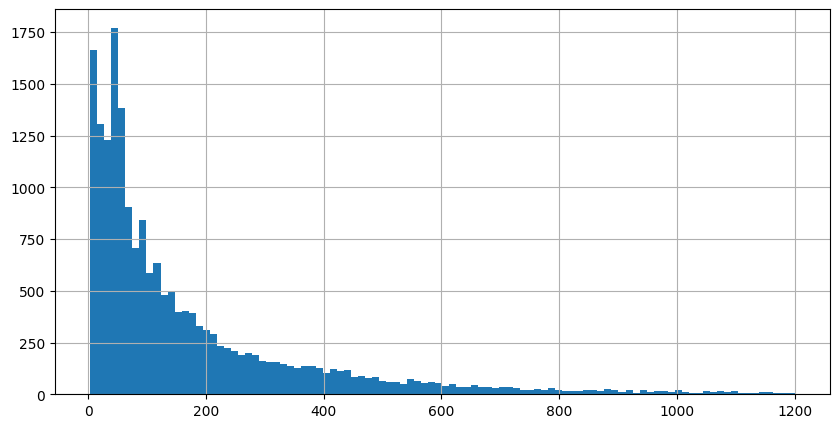

In [149]:
df['days_exposition'].hist(figsize=(10,5), bins=100);

Гистограмма это подтверждает, давайте посмотрим boxplot.

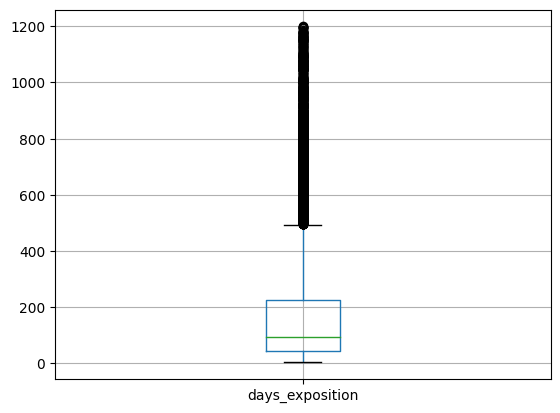

In [150]:
df.boxplot(column='days_exposition');

На этом графике хорошо видны выбросы - более 500 дней, отбросим их.

(0.0, 510.0)

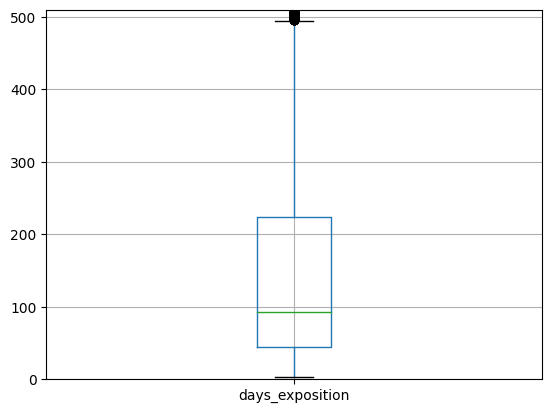

In [151]:
df.boxplot(column='days_exposition');
plt.ylim(0, 510)

*Если присвивать категории, то я бы опирался на этот график:*
- *быстрые продажи до 45 дней*
- *нормальный срок от 45 до 230*
- *долгие до 500 дней*
- *а все что выше 500 дней, это аномально долгий срок. С вашим объявлением точно что-то не так.*

In [152]:
df.groupby('year_publication')['days_exposition'].agg(['count', 'mean', 'median'])

,count,mean,median
year_publication,,,
2014,85,805.11,752.00
2015,941,602.10,547.00
2016,2492,320.64,233.00
2017,7384,157.61,102.00
2018,7074,93.20,63.00
2019,1004,30.81,23.00


Создали таблицу со средним и медианным значением скорости продаж по годам. Визуализируем ее по среднему значению, исключим 2014 год из графика, потому что там всего 95 значений.

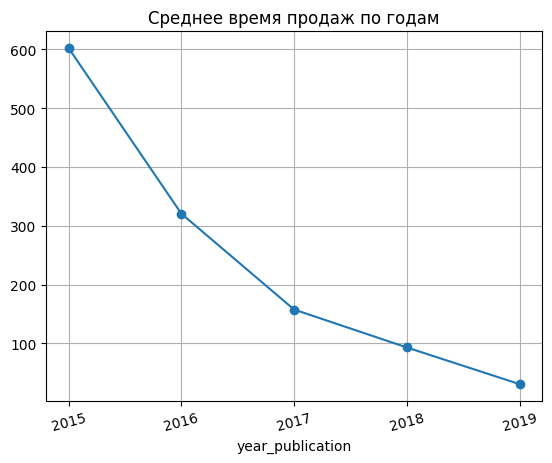

In [153]:
(df.query('year_publication != 2014') \
  .groupby('year_publication')['days_exposition'] \
  .agg('mean') \
  .plot(grid=True, marker='o'))
plt.title('Среднее время продаж по годам');
plt.xticks(np.arange(2015, 2020, step=1));
plt.xticks(rotation=15)
plt.show()

Видна явная тенденция на сокращение сроков продаж квартир. Разница в скорости продаж между 2015 и 2019 годов более чем в 6 раз выглядет очень странно.

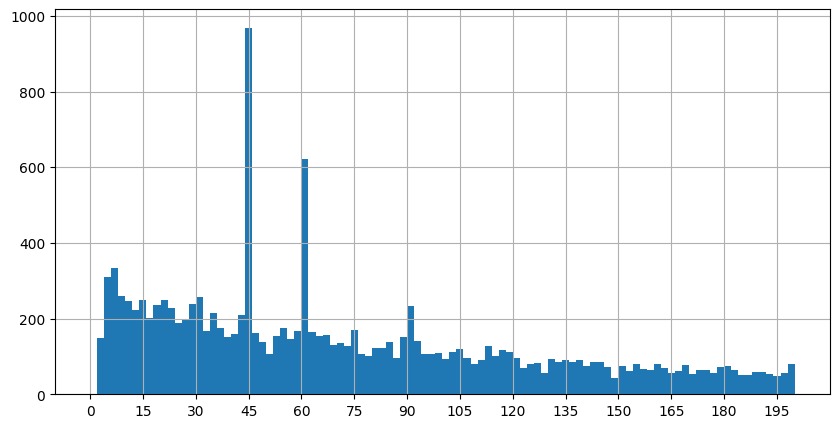

In [154]:
df['days_exposition'].hist(figsize=(10,5), bins=100, range=(0,200));
plt.xticks(np.arange(0, 200, step=15));

Присмотревшись к графику мы видим две высоких колонки. Это объясняется тем, что по условиям яндекс-недвижимости сроки бесплатных публикации составляют:  
до 4,5 млн — 45 дней  
от 4,5 до 10 млн — 60 дней  
от 10 млн — 90 дней  
Далее объявление становится платным.

#### Задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);

Создадим таблицу только с нужными нам столбцами.
Логично предположить что самые дорогие квартиры будут в столице региона, поэтому будем рассмтаривать только квартиры из Санкт-Петербурга.

In [155]:
price_analysis = df.query('locality_name == "Санкт-Петербург"') \
                [['last_price','price_per_meter','total_area', \
                  'living_area','kitchen_area','rooms','floor_type', \
                  'weekday_publication', 'month_publication','year_publication']].reset_index(drop=True)

In [156]:
price_analysis.head()

,last_price,price_per_meter,total_area,living_area,kitchen_area,rooms,floor_type,weekday_publication,month_publication,year_publication
0,13000000,120370,108.00,51.00,25.00,3,другой,3,3,2019
1,5196000,92786,56.00,34.30,8.30,2,другой,3,8,2015
2,64900000,408176,159.00,89.23,NaN,3,другой,4,7,2015
3,7915000,110545,71.60,40.18,18.90,2,другой,3,4,2019
4,5400000,88525,61.00,43.60,6.50,3,другой,6,2,2017


Рассмотри зависимость от типа этажа.

In [157]:
price_analysis.groupby('floor_type')['last_price'].agg(['count','mean']).sort_values('mean')

,count,mean
floor_type,,
первый,1479,"5,622,293.45"
последний,1653,"6,898,621.62"
другой,11186,"6,938,435.28"


В среднем квартиры на последнем этаже стоят дороже. Визуализируем это.

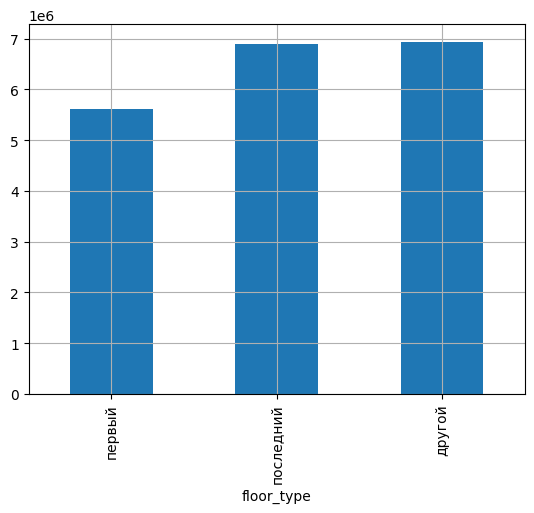

In [158]:
price_analysis.groupby('floor_type')['last_price'].agg('mean').sort_values().plot(kind='bar', grid=True);

На графике видно, что квартиры на последнем этаже самые дорогие.
На первом этаже самые дешевые, в среднем разница между первым и поледним этажом соствляет около 2млн руб.  

Проанализруем данные по количеству комнат.

In [159]:
price_analysis['rooms'].value_counts()

2    4789
1    4665
3    3752
4     811
5     166
0     100
6      25
7      10
Name: rooms, dtype: int64

По количеству комнат получается слишком много категорий, объединим данные в три группы:  
* 1комнатные (где 0,1 комната)
* 2хкомнатные (где 2комнаты)
* многокомнатные(где 3 и больше комнат)

In [160]:
def categorize_rooms(room):

    if (room == 0) or (room == 1):
        return '1-комнатная'
    elif room == 2:
        return '2-комнатная'
    else:
        return 'многокомнатная'

# Проверим функцию
print(categorize_rooms(0))
print(categorize_rooms(2))
print(categorize_rooms(5))

1-комнатная
2-комнатная
многокомнатная


In [161]:
price_analysis['rooms_type'] = price_analysis['rooms'].apply(categorize_rooms)

In [162]:
price_analysis.groupby('rooms_type')['last_price'].agg(['count','mean'])

,count,mean
rooms_type,,
1-комнатная,4765,"4,412,267.26"
2-комнатная,4789,"6,409,538.12"
многокомнатная,4764,"9,574,391.08"


Получились практически равные группы по количеству.

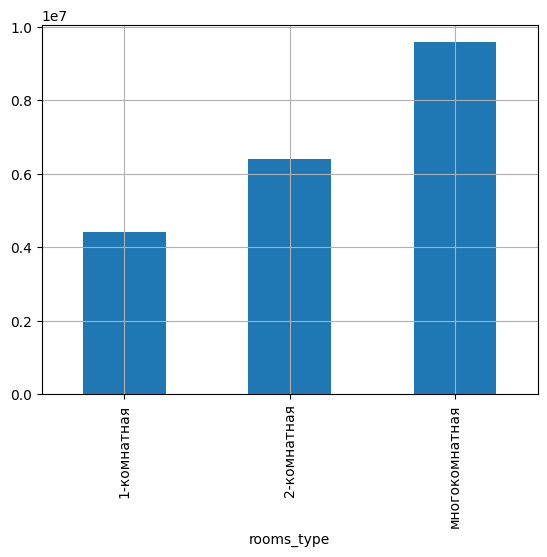

In [163]:
price_analysis.groupby('rooms_type')['last_price'].agg('mean').sort_values().plot(kind='bar', grid=True);

Получили очевидный график -  с ростом комнат растет и цена.  
Посмотрим как это соотносится с ценой за 1м2.

In [164]:
price_analysis.groupby('rooms_type')['price_per_meter'].agg(['count','mean'])

,count,mean
rooms_type,,
1-комнатная,4765,"115,112.83"
2-комнатная,4789,"110,129.27"
многокомнатная,4764,"107,729.08"


Если рассматривать в разрезе цен за 1м2, то ситацию противоположная, чем меньше комнат - тем дороже цена за 1 м2.

Рассмотрим есть ли зависимоcть от того, в какой день недели была опубликована квартира.

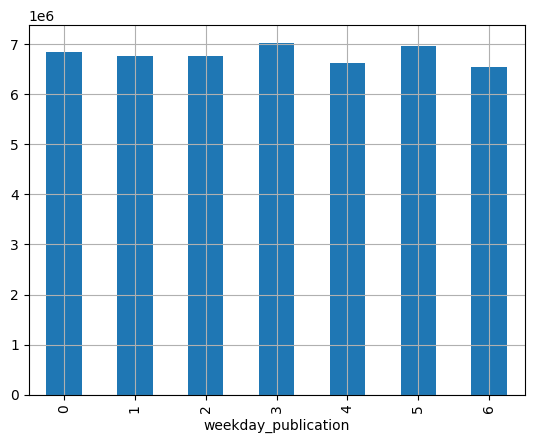

In [165]:
price_analysis.groupby('weekday_publication')['last_price'].agg('mean').plot(kind='bar', grid=True);

Все столбцы примерно одинаковые, соответсвенно делаем вывод что стоимость от дня недели не зависит.

In [166]:
price_analysis.groupby('month_publication')['last_price'].agg(['count','mean'])

,count,mean
month_publication,,
1,826,"6,893,605.24"
2,1587,"6,845,870.86"
3,1525,"6,683,432.07"
4,1481,"6,676,419.54"
5,780,"6,776,370.53"
6,1059,"6,823,493.21"
7,1027,"6,617,439.63"
8,1103,"6,817,586.31"
9,1216,"6,970,968.03"


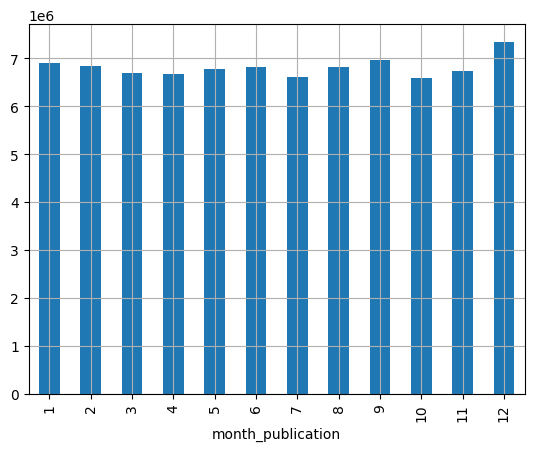

In [167]:
price_analysis.groupby('month_publication')['last_price'].agg('mean').plot(kind='bar', grid=True);

По месяцам все квартиры находятся в диапазоне 7-8 млн руб.

Рассмотрим распределение стоимости по годам.

In [168]:
price_analysis.groupby('year_publication')['last_price'].agg(['count','mean'])

,count,mean
year_publication,,
2014,72,"12,371,000.47"
2015,697,"7,767,311.51"
2016,1698,"7,086,630.82"
2017,5071,"6,604,400.68"
2018,4969,"6,581,289.78"
2019,1811,"7,068,558.03"


В 2014 году слишком мало объявлений, при пострении графика отфультруем эти значения.

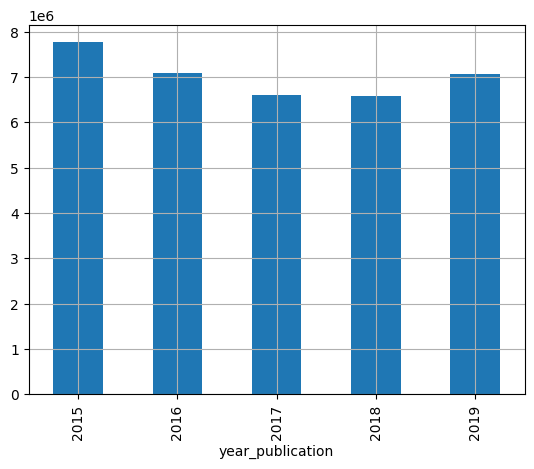

In [169]:
price_analysis.query('year_publication > 2014') \
              .groupby('year_publication')['last_price'].agg('mean') \
              .plot(kind='bar', grid=True);

Цены по годам распределены примерно одинаково, только выделяется 2015 год, там средняя цена квартиры чуть выше.

In [170]:
(
df.query('(year_publication > 2014) and (locality_name == "Санкт-Петербург")')
  .pivot_table(index='year_publication', 
               values=['total_area','last_price','price_per_meter'], 
               aggfunc={'total_area':['mean', 'median'],
                        'price_per_meter':['mean', 'median'],
                        'last_price':['count','mean', 'median'],})
)

last_price                           price_per_meter  \
                      count         mean       median            mean   
year_publication                                                        
2015                 697.00 7,767,311.51 5,780,000.00      110,963.90   
2016               1,698.00 7,086,630.82 5,300,000.00      108,801.96   
2017               5,071.00 6,604,400.68 5,150,000.00      107,555.72   
2018               4,969.00 6,581,289.78 5,300,000.00      111,659.60   
2019               1,811.00 7,068,558.03 5,700,000.00      119,842.78   

                            total_area         
                     median       mean median  
year_publication                               
2015             100,000.00      66.59  60.00  
2016             100,000.00      62.18  55.00  
2017             100,543.00      59.50  53.00  
2018             105,477.00      57.90  52.00  
2019             112,527.00      58.05  52.40

Интересная тенденция, что в 2015, 2016, 2017 году медианная стоимость квартир в СПБ не изменялась, начиная с 2018 года стала демонстрировать рост. Визуализируем данные по средней цене, площади и цене за 1 м2.

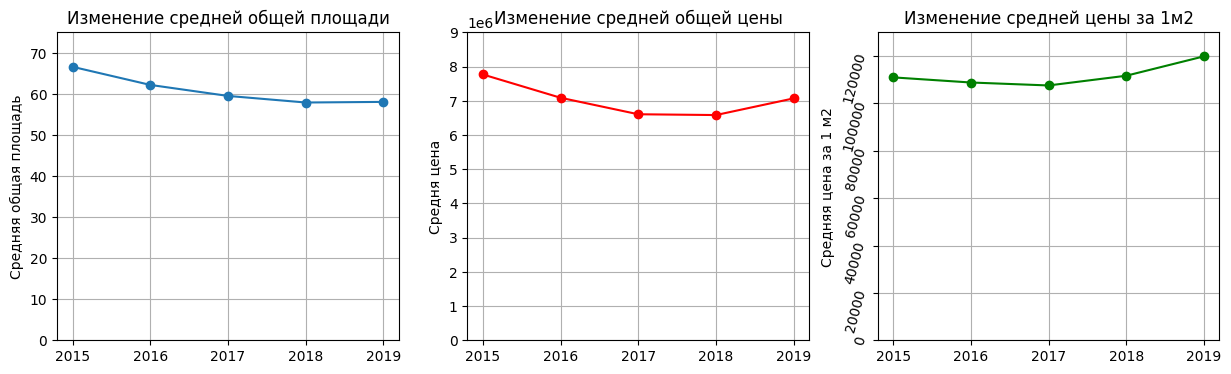

In [171]:
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.plot(df.query('(year_publication > 2014) and (locality_name == "Санкт-Петербург")')
                  .pivot_table(index='year_publication', 
                               values='total_area', 
                               aggfunc='mean'), marker='o');
ax2.plot(df.query('(year_publication > 2014) and (locality_name == "Санкт-Петербург")')
                  .pivot_table(index='year_publication', 
                               values='last_price', 
                               aggfunc='mean'), marker='o', color='red');
ax3.plot(df.query('(year_publication > 2014) and (locality_name == "Санкт-Петербург")')
                  .pivot_table(index='year_publication', 
                               values='price_per_meter', 
                               aggfunc='mean'), marker='o', color='green');
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)


ax1.set_ylim(0,75)
ax2.set_ylim(0,9000000)
ax3.set_ylim(0,130000)

ax1.set(title = 'Изменение средней общей площади')
ax2.set(title = 'Изменение средней общей цены')
ax3.set(title = 'Изменение средней цены за 1м2')

ax1.set_ylabel('Средняя общая площадь');
ax2.set_ylabel('Средня цена');
ax3.set_ylabel('Средняя цена за 1 м2');

plt.yticks(rotation=75);

По средней площади видна небольшая тенденция на уменьшение общей площади квартир. Это тянет за собой и снижение общей цены, кроме 2019 года, связно это с тем, если мы посмотрим на среднюю цена за 1 м2, то с 2017 года виден рост этого признака.

Для того чтобы посмотреть как цена зависит от разного вида площадей, построим диграмму рассеивания.

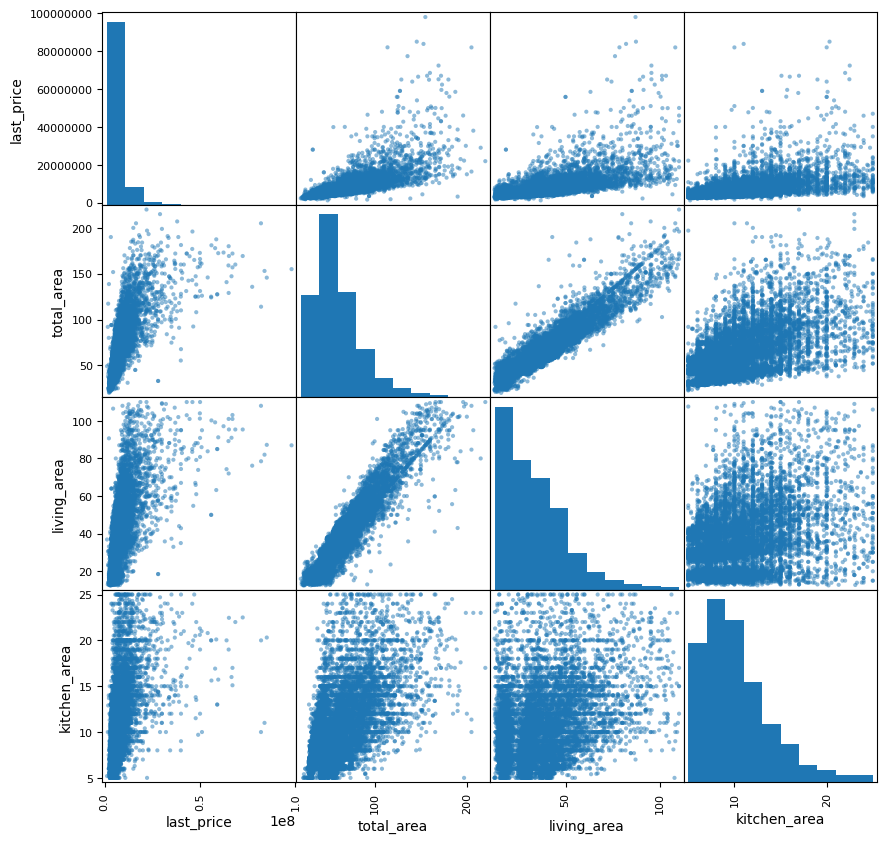

In [172]:
pd.plotting.scatter_matrix(price_analysis[['last_price','total_area','living_area', 'kitchen_area']], figsize=(10,10));
plt.show()

На графиках видно, что все показатели связаны между собой. С ростом общей площади расчет и жилая площадь и кухня и соответственно цена квартиры.  
Посмотрим как меняется цена за 1м2 в зивисимости от категории, разобъем общую площадь на 4 категории и пострим сводную таблицу.

In [173]:
price_analysis['total_area_type'] = pd.qcut(price_analysis['total_area'],q=4)

In [174]:
price_analysis.groupby('total_area_type')['price_per_meter'].agg(['count','mean'])

,count,mean
total_area_type,,
"(19.999, 41.3]",3581,"112,655.90"
"(41.3, 53.4]",3584,"104,737.36"
"(53.4, 70.9]",3582,"105,369.16"
"(70.9, 220.0]",3571,"121,229.71"


Деление по группам произошло успешно.

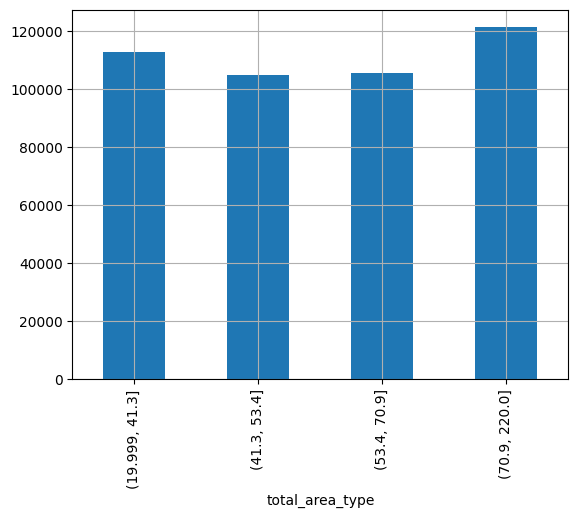

In [175]:
price_analysis.groupby('total_area_type')['price_per_meter'].agg('mean').plot(kind='bar', grid=True);

Получили интересную картину, дороже цены за м2 в самых больших квартирах и самых маленьких.  
Мы уже видиели цена за 1м2 в 1-комнатных квартирах дороже чем в других.
А дорогую стоимость квдратного метра в квартирах более 74м2 можно объяснить тем, что в этой категории находятся все самые дорогие квартиры с боьшой площадью и вероятно что там так же выполнен дорогой ремонт, что и повлияло на цену. 

*В результате анализа мы выяснили:*
- *Время публикации не влияет на цену квартиры.*
- *Самые дешевые квартиры продаются на первом этаже.*
- *С ростом общей площади растет и жилая площадь, и кухня, и конечная цена.*
- *Если рассматривать в разрезе стоимости квадратного метра, то в однокомнатных и студиях в средем стоимость квадратного метра дороже.*

Для поиска линейных зависимостей обратимся к коэф. корреляции.

In [176]:
corr = price_analysis.corr()

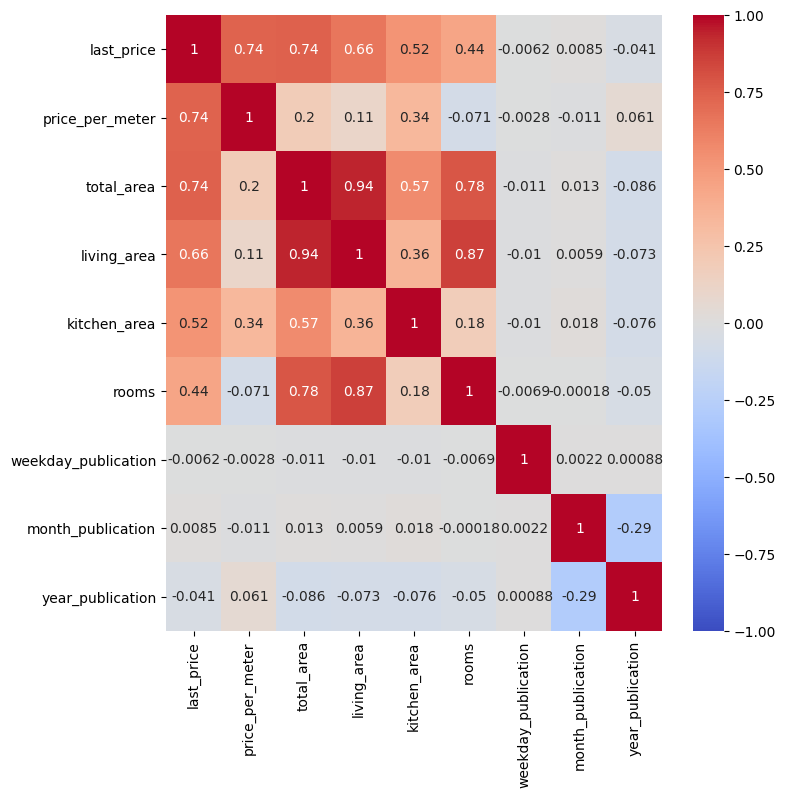

In [177]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr, cmap="coolwarm", annot=True, vmin=-1, vmax=1, fmt='.2g', ax=ax);

Из матрицы коррелияции мы видем следующую линейную связь у последней цены: 
- высокая связь с ценой за 1м2, общей площадью.
- средняя связь с жилой площадью и площадью кухни.
- слабую связь с кол-вом комнат.
- отсутвует связь с датой размещения объявления.

В тоже время обращаем внимание очень сильную связь общей площаи и жилой площади и на сильную связь общей площади с кол-вом комнат. А кол-во комнот в свою очередь сильно связаны с жилой площадью.

#### Задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

Найдем 10 населенных пунктов с наибольшим количеством объявлений.

In [178]:
df['locality_name'].value_counts().head(10)

Санкт-Петербург      14318
Мурино                 556
Кудрово                449
поселок Шушары         423
Всеволожск             377
Пушкин                 340
Колпино                332
поселок Парголово      312
Гатчина                292
Выборг                 215
Name: locality_name, dtype: int64

Сформируем сводную таблицу с этими населенными пунктами.

In [179]:
list= ['Санкт-Петербург','Мурино','Кудрово','поселок Шушары', \
       'Всеволожск','Пушкин','Колпино','поселок Парголово','Гатчина','Выборг' ]

In [180]:
(df.query('locality_name in @list')
   .groupby('locality_name')['price_per_meter'].agg(['count','mean'])
   .sort_values('mean', ascending=False))

,count,mean
locality_name,,
Санкт-Петербург,14318,"110,989.18"
Пушкин,340,"102,020.34"
Кудрово,449,"95,269.96"
поселок Парголово,312,"89,803.34"
Мурино,556,"85,599.71"
поселок Шушары,423,"78,172.42"
Колпино,332,"75,444.81"
Гатчина,292,"68,676.53"
Всеволожск,377,"68,242.48"


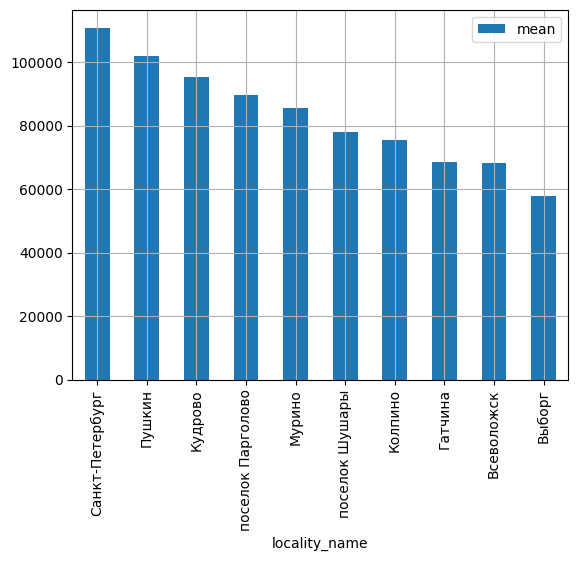

In [181]:
(df.query('locality_name in @list')
   .groupby('locality_name')['price_per_meter'].agg(['mean'])
   .sort_values('mean', ascending=False)
   .plot(kind='bar', grid=True));
plt.show()

*Среди ТОП-10 насленных пунктов по количеству объявлений.  
Самая дорогая средняя цена 1 м2 в Санкт-Петербурге - 113 365 руб.  
Самая дешевая средняя цена 1 м2 в Выборге - 58 238 руб.*

#### Задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца *locality_name* и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."

Давайте посмотрим как зависят между собой цена и расстояние в км от центра.

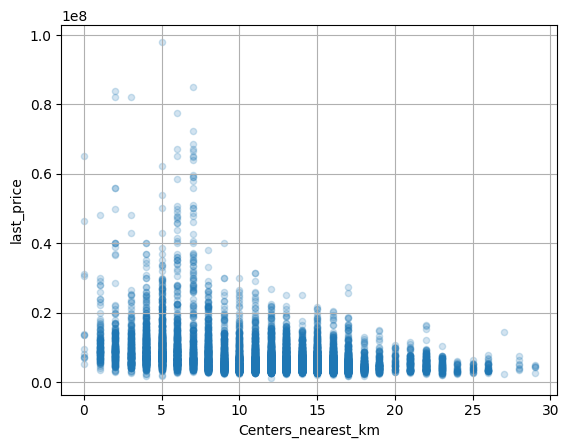

In [182]:
df.query('locality_name == "Санкт-Петербург"') \
  .plot(x='Centers_nearest_km', y='last_price', kind='scatter', grid=True, alpha=0.2);

Видим что в радиусе 10км встрачаются самые дорогие квартиры, далее их частота становится все меньше и меньше.

Составим сводную таблицу для квартир только из Санкт-Петербурга, сгруппируем по удаленности от центра и вычислеим среднюю цену на каждом км.

In [183]:
df.query('locality_name == "Санкт-Петербург"').groupby('Centers_nearest_km')['last_price'].agg(['count','mean']).head()

,count,mean
Centers_nearest_km,,
0.00,13,"19,862,544.00"
1.00,128,"11,277,812.50"
2.00,209,"11,851,349.28"
3.00,267,"9,756,352.81"
4.00,551,"9,984,060.42"


Для наглядности визуализируем эти данные.

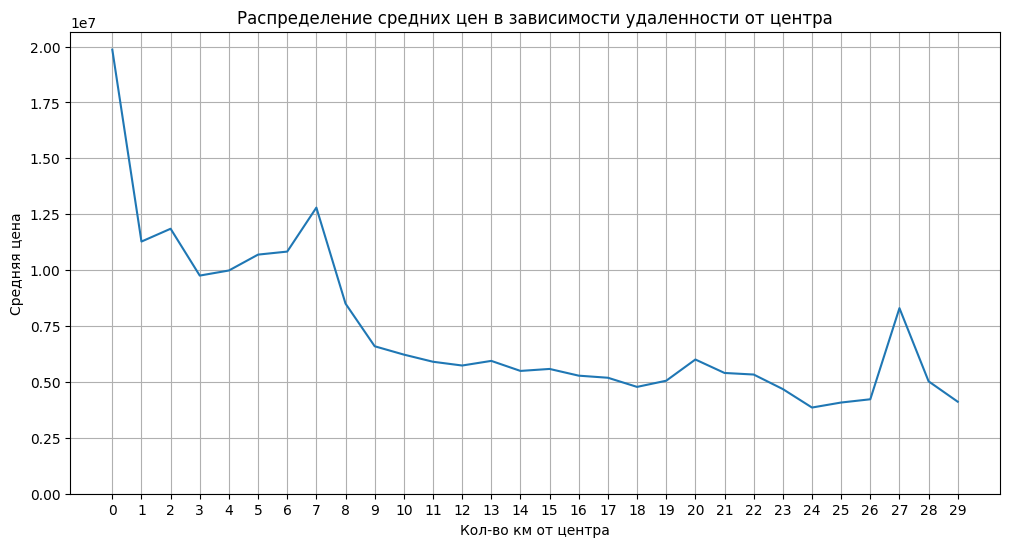

In [184]:
fig = plt.figure(figsize=(12,6))
df.query('locality_name == "Санкт-Петербург"').groupby('Centers_nearest_km')['last_price'].agg('mean').plot(grid=True, ylim=0);
plt.xticks(np.arange(0, 30, step=1));
plt.xlabel('Кол-во км от центра');
plt.ylabel('Средняя цена');
plt.title('Распределение средних цен в зависимости удаленности от центра');

Видна динамика, чем дальше от центра, тем дешевле квартиры.  
Помимо этого идет аномальный рост средней цены в районе 3-7км.  
Так же графике присутствует пик на 27 км, сначала изучим этом пик.

In [185]:
df.query('(Centers_nearest_km == 27) and (locality_name == "Санкт-Петербург")').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday_publication,month_publication,year_publication,floor_type,Centers_nearest_km
748,13,14350000,74.00,2017-11-28,2,3.13,5,30.00,3,False,25.00,0,Санкт-Петербург,"23,888.00","27,313.00",1.00,"1,496.00",0.00,NaN,128.00,193919,1,11,2017,другой,27.00
5961,6,2250000,32.00,2018-02-27,1,2.65,2,16.50,2,False,7.00,0,Санкт-Петербург,"24,006.00","27,431.00",0.00,NaN,0.00,NaN,178.00,70312,1,2,2018,последний,27.00


На 27 км всего две квартиры и одна с ценой, площадью и потолками больше средних значений, соответственно пик на графике образовался из-за недостаточной выборки. Выведем всю талицу на экран.

In [186]:
df.query('locality_name == "Санкт-Петербург"').groupby('Centers_nearest_km')['last_price'].agg(['count','mean'])

,count,mean
Centers_nearest_km,,
0.00,13,"19,862,544.00"
1.00,128,"11,277,812.50"
2.00,209,"11,851,349.28"
3.00,267,"9,756,352.81"
4.00,551,"9,984,060.42"
5.00,722,"10,694,508.64"
6.00,505,"10,829,369.26"
7.00,367,"12,796,867.71"
8.00,544,"8,502,551.60"


Как мы видим в целом на 27,28,29 км от центра продается совсем мало квартир.

Давайте теперь рассмотрим квартиры квартиры на 3, 5 и 7 этаже.

In [187]:
(
df.query('(Centers_nearest_km == [3,5,7]) and (locality_name == "Санкт-Петербург")')
  .pivot_table(index='Centers_nearest_km', 
               columns='floor_type', 
               values=['last_price', 'total_area','price_per_meter'], 
               aggfunc={'last_price':['count','mean'],
                        'total_area':'mean',
                        'price_per_meter':'mean'}).T
)

Centers_nearest_km                        3.00          5.00          7.00
                      floor_type                                          
last_price      count другой            157.00        547.00        285.00
                      первый             46.00         70.00         30.00
                      последний          64.00        105.00         52.00
                mean  другой     10,555,750.31 11,049,943.76 13,684,034.13
                      первый      7,314,845.65  7,711,442.13  9,461,857.37
                      последний   9,550,164.06 10,831,571.89  9,858,557.69
price_per_meter mean  другой        124,658.76    137,426.60    157,252.56
                      первый        109,006.28    110,741.56    122,783.27
                      последний     115,383.09    131,844.07    128,639.69
total_area      mean  другой             84.20         80.00         76.43
                      первый             66.06         70.88         68.90
                      последний          84.15         83.61         67.04

Выборка по каждой категории достаточно неплохая - минимум 30 квартир.  
Если рассматривать категорию квартир на "другом" этаже, где уже минимум 157 квартир, то видно как сильно растет цена за 1м2 с увеличием отдаленности от центра, что пока сложно объяснить.
Так же разница между 3, 5 и 7 этажом складывается из-за того, что на 3 этаже 40% всех квартир находятся на крайних этажах, где цена за 1м2 ниже чем на других этажах.

### Общий вывод

<div style="border:solid green 2px; padding: 20px">

Исходные данные — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.  
Цель: Опредлить признаки которые влияют на конечную стоимость объекта.  

1. **Предобработка данных.**

На этапе предобработки была проделана следующая работа:  
*Пропуски*  
Были определены столбцы с пропусками. Пропуски заполнили следующиим образом:
- *Высота потолка: медианным значением.*
- *Кол-во этажей в доме: было 0,3% пропусков, мы удалили эти квартиры.
- *Жилая площадь: линейным коэф. 0,56 умноженную на общую площадь.*
- *Балконы: нулем, предположили что балконов нет в этих квартирах.*
- *Название населённого пункта: удалили строки с пустыми значениями.*
*Так же был удален столбец 'апартаменты', из-за недостаточного количества данных.*

*Аномалии*  
Мы отфильтровали и оставили следующие квартиры:  
- *стоимостью от 500К до 100млн руб.*
- *площадью от 20 до 300м2.*
- *до 7 комнат включительно.*
- *с потолками от 2,4 до 3,5м.*
- *жилой площадью от 12,5 до 110 м2.*
- *площадью кухни от 5 до 25 м2.*
- *общем количеством - до 37 включительно.*
- *удалили данные о свободных планировках, т.к. столбец не нес никакой информации.*

В результате мы удалили около 8% от исходных данных.
    
*Доп. информация*  
Добавили в datafreme необходимые для анализа данные  
- *price_per_meter (цена за 1 квадратный метр)*
- *weekday_publication (день публикации объявления)*
- *month_publication (месяц публикации объявления)*
- *year_publication (год публикации объявления)*
- *floor_type(тип этажа квартиры)*
- *cityCenters_nearest_km(расстояние в км до центра города)*

2. **Анализ данных.**
На стоимость квартиры влияют следующие признаки:
- *Тип этажа. Самые дешевые квартиры продаются на первом этаже.*
- *Общая площадь. Чем больше площадь, тем дороже квартира.*
- *Тип квартиры. Стоимость студий и однокомнатных квартир в среднем дороже остальных квартир.*
- *Населенный пункт в котором продается квартира. Если рассматривать ТОП-10 населенных пунктов по кол-ву объявлений. Самая дорогая средняя цена 1 м2 в Санкт-Петербурге - 110 989 руб. Самая дешевая средняя цена 1 м2 в Выборге - 57 907 руб.*
- *Для Санкт-Петербурга удаление от центра. Чем дальше квартира от центра города, тем дороже.*

Мы выявили что с 2015 года по 2019 наблюдаются следующие тенденции:
- уменьшения среднего срока продаж.
- уменьшение средней общей площади квартир.
- увеличение средней цены за 1м2.